# Predictive Quality Additive Manufacturing

## Libraries

All necessary packages 

In [75]:
!pip install openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
from scipy.signal import butter, filtfilt
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import Data
to get **list_Audio** store the measurement data and **id_Audio** including the number of measurement

In [2]:
# change data_path according to the path of data
current_path = os.getcwd()
print("current pth:", current_path)
#data_path = os.path.dirname(current_path)
if os.path.exists("02_Data"):
    data_path = ("02_Data")
    print("Data has been founded at:", data_path)
else:
    print("Can`t find Data")
Audio_path = os.path.join(data_path,"01_Audio")
#print("Audio:", Audio_path)
Audio_files = [ f for f in os.listdir(Audio_path) if f.endswith(".csv")]
print("Audio_files are: ", Audio_files)
list_Audio = []
id_Audio = []
for file_name in Audio_files:
    file_path = os.path.join(Audio_path,file_name)
    #get data
    df = pd.read_csv(file_path)
    list_Audio.append(df)
    #get data id
    id_Audio.append(int(os.path.splitext(os.path.basename(file_path))[0]))
print("Audio_len: ",len(list_Audio))
print("shape of list_Audio:", list_Audio[0].shape) 


Weldqas_path = os.path.join(data_path,"02_Weldqas")
Weldqas_files = [ j for j in os.listdir(Weldqas_path) if j.endswith(".csv")]
print("Weldqas_files are: ", Weldqas_files)
list_Weldqas = []
for file_name in Weldqas_files:
    file_path = os.path.join(Weldqas_path,file_name)
    df = pd.read_csv(file_path)
    list_Weldqas.append(df)
print("Weldqas_len: ",len(list_Weldqas))
print("shape of list_Weldqas:", list_Weldqas[0].shape) 
##get the path o excel
excel_paths = []
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".xlsx"):
            excel_paths.append(os.path.join(data_path,file))
print(excel_paths)

current pth: c:\Users\13370\Desktop\SS25\KI_in_der_Produktionstechnik\Project\PQAM
Data has been founded at: 02_Data
Audio_files are:  ['169.csv', '170.csv', '171.csv', '172.csv', '173.csv', '174.csv', '175.csv', '176.csv', '177.csv', '178.csv', '179.csv', '180.csv', '181.csv', '182.csv', '183.csv', '184.csv', '185.csv', '186.csv', '187.csv', '188.csv', '189.csv', '190.csv', '191.csv', '192.csv', '193.csv', '194.csv', '195.csv', '196.csv', '197.csv', '198.csv', '199.csv', '200.csv', '201.csv', '202.csv', '203.csv', '204.csv', '205.csv', '206.csv', '207.csv', '208.csv', '209.csv', '210.csv', '211.csv', '212.csv', '213.csv', '214.csv', '215.csv', '216.csv', '217.csv', '218.csv', '219.csv', '220.csv', '221.csv', '222.csv', '223.csv', '224.csv', '225.csv', '226.csv', '227.csv', '228.csv', '229.csv', '230.csv', '231.csv', '232.csv', '233.csv', '234.csv', '235.csv', '236.csv', '237.csv', '238.csv', '239.csv', '240.csv', '241.csv', '242.csv', '243.csv', '244.csv', '245.csv', '246.csv', '247.c

Read Excel
**audio_list_with_labels** is the combination of audio and label

In [3]:
#get the header of table
excel_df = pd.read_excel(excel_paths[0], sheet_name=0,skiprows=10)
print(excel_df.columns)
df_Usage = excel_df[["Number of Measurement",'Dataset']]
"""
Audio_df_without_label = pd.DataFrame({
    "Number of Measurement": id_Audio,
    "DAta of Audio": list_Audio
})
"""
label_map = dict(zip(df_Usage["Number of Measurement"], df_Usage["Dataset"]))

# conbine csv data with excel
audio_list_with_labels = []

for id_, audio in zip(id_Audio, list_Audio):
    label = label_map.get(id_, None)  
    audio_list_with_labels.append({
        "id": id_,
        "audio": audio,
        "label": label
    })

print(audio_list_with_labels[0])

Index(['Unnamed: 0', 'Number of Measurement', 'Experiment', 'Process',
       'Usable', 'Dataset', 'Audio', 'Currency I [A]', 'Time [ms]',
       'Eintauchmaß p [mm]', 'Hub h [mm]', 'Forced Error Type',
       'Coaxial Offset [mm]', 'Tilt [°]', 'Notes'],
      dtype='object')
{'id': 169, 'audio':          Unnamed: 0       Time    M
0                 0   0.000000   28
1                 1   0.000021   26
2                 2   0.000042   23
3                 3   0.000063   27
4                 4   0.000083   22
...             ...        ...  ...
1021947     1021947  21.290563  216
1021948     1021948  21.290583  227
1021949     1021949  21.290604  242
1021950     1021950  21.290625  249
1021951     1021951  21.290646  263

[1021952 rows x 3 columns], 'label': 'iO'}


# Predefined Functions

### Audio part

#### Read a single file and print it out

In [4]:
# read single file
#file_path = os.path.join(Audio_path,"169.csv")
#df = pd.read_csv(file_path)
#pd.set_option('display.max_rows', None)
def ReadSingleAudio(id_Audio,audio_list_with_labels):
    for sample in audio_list_with_labels:
        
        if sample['id'] == id_Audio:
                 
            df = pd.DataFrame({
                "Measurement": sample['audio']['M'],
                "Time":sample['audio']['Time'],
                
                })
            
            #print(df)
            #df.info()
            x = df["Time"]
            y = df["Measurement"]
            plt.figure(figsize=(30, 4)) 
            plt.plot(x,y)

            plt.xlabel("Time (s)")
            plt.ylabel("Measurement ")
            plt.title(f" Audio ID : {id_Audio} | Label :{sample['label']}")
            plt.show()




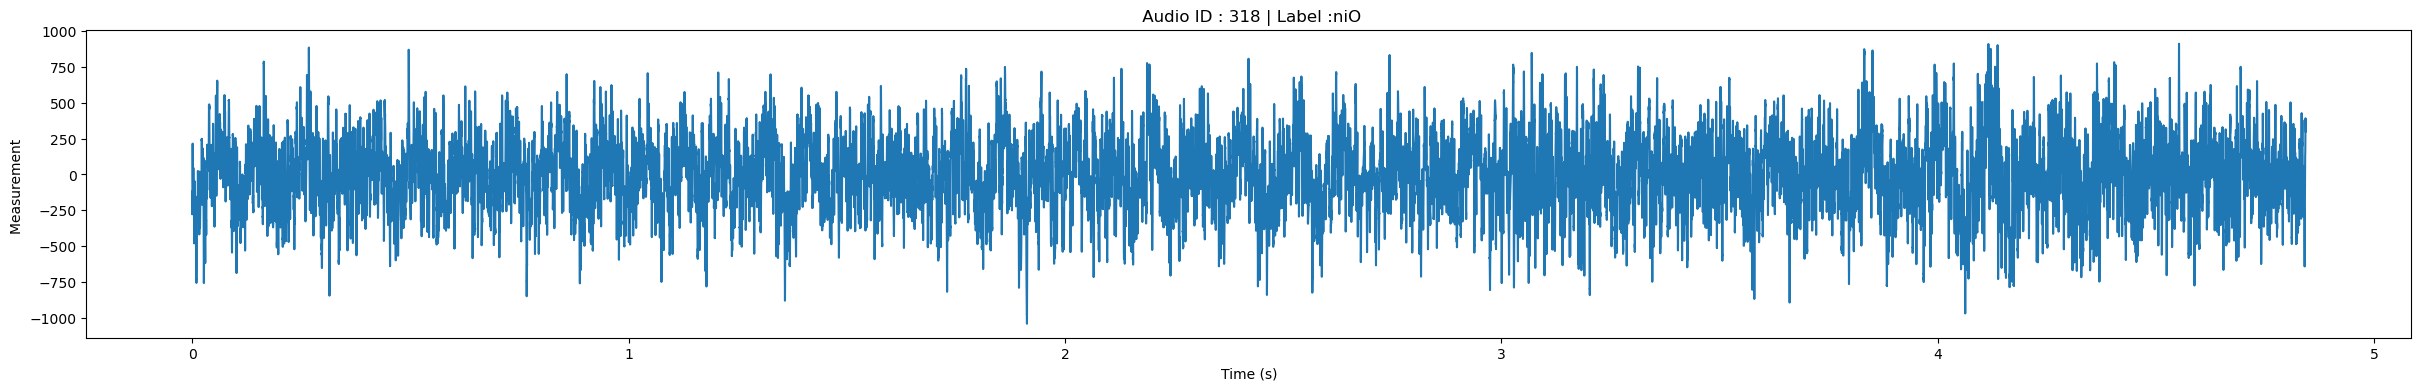

In [5]:
ReadSingleAudio(318,audio_list_with_labels)

#### High-pass fliter

In [6]:
#define high-pass filter
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs              # Nyquist frequency
    normal_cutoff = cutoff / nyq                # Normalize the cutoff frequency
    b, a = butter(order, normal_cutoff, btype='high', analog=False)             #filter coefficients
    return b, a

#define high-pass filter function
def highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)             #get filter coefficients
    y = filtfilt(b, a, data)                #Apply zero-phase filtering to avoid phase distortion
    return y

#### Noise remove

In [7]:
# =============================================================================
THRESHOLD = 100 # <-- Change this value as needed
# =============================================================================
def extract_effective_segment(time_data, filtered_signal, threshold=THRESHOLD):
    """
    Extract only the effective segment (above threshold) from the signal
    
    Parameters:
    - time_data: time array
    - filtered_signal: signal amplitude array
    - threshold: amplitude threshold for determining effective signal
    
    Returns:
    - effective_time: time data for effective segment
    - effective_signal: signal data for effective segment
    """
    signal_active = np.abs(filtered_signal) > threshold
    
    if not np.any(signal_active):
        # If no signal above threshold, return empty arrays
        return np.array([]), np.array([])
    
    # Find start and end indices of effective segment
    active_indices = np.where(signal_active)[0]
    start_idx = active_indices[0]
    end_idx = active_indices[-1]
    
    # Extract effective segment
    effective_time = time_data[start_idx:end_idx+1]
    effective_signal = filtered_signal[start_idx:end_idx+1]
    
    # Reset time to start from 0
    effective_time = effective_time - effective_time[0]
    
    return effective_time, effective_signal

def process_all_audio_effective(audio_list):
   """
   Process all audio files to keep only effective segments
   
   Parameters:
   - audio_list: list of audio data to process
   
   Returns new audio list with noise removed
   """
   processed_audio_list = []
   removed_count = 0
   total_original_points = 0
   total_effective_points = 0
   
   print(f"Processing {len(audio_list)} audio files...")
   print(f"Using THRESHOLD = {THRESHOLD}")
   print("-" * 60)
   
   for audio_data in tqdm(audio_list, desc="Removing noise"):
       measurement_id = audio_data['id']
       df_filtered = audio_data['audio']
       original_label = audio_data['label']
       
       # Extract data
       time_data = df_filtered['Time'].values
       filtered_signal = df_filtered['M'].values
       
       # Count original points
       original_points = len(time_data)
       total_original_points += original_points
       
       # Extract effective segment
       effective_time, effective_signal = extract_effective_segment(
           time_data, filtered_signal, THRESHOLD)
       
       if len(effective_time) == 0:
           # No effective signal found - skip this measurement
           print(f"Warning: No effective signal found for measurement {measurement_id}")
           removed_count += 1
           continue
       
       # Count effective points
       effective_points = len(effective_time)
       total_effective_points += effective_points
       
       # Create new DataFrame with effective data only
       effective_df = pd.DataFrame({
           'Unnamed: 0': range(len(effective_time)),
           'Time': effective_time,
           'M': effective_signal
       })
       
       # Create new audio data entry
       processed_audio_data = {
           'id': measurement_id,
           'audio': effective_df,
           'label': original_label
       }
       
       processed_audio_list.append(processed_audio_data)
   
   # Print processing summary
   print(f"\nProcessing Summary:")
   print(f"Original measurements: {len(audio_list)}")
   print(f"Processed measurements: {len(processed_audio_list)}")
   print(f"Removed measurements (no effective signal): {removed_count}")
   print(f"Total original data points: {total_original_points:,}")
   print(f"Total effective data points: {total_effective_points:,}")
   print(f"Data reduction: {(1 - total_effective_points/total_original_points)*100:.1f}%")
   
   return processed_audio_list

def compare_before_after(measurement_id, original_list, processed_list):
    """
    Compare original and processed audio for a specific measurement
    """
    # Find original data
    original_data = None
    for data in original_list:
        if data['id'] == measurement_id:
            original_data = data
            break
    
    # Find processed data
    processed_data = None
    for data in processed_list:
        if data['id'] == measurement_id:
            processed_data = data
            break
    
    if original_data is None or processed_data is None:
        print(f"Measurement {measurement_id} not found in one of the lists!")
        return
    
    # Extract data
    orig_df = original_data['audio']
    proc_df = processed_data['audio']
    label = original_data['label']
    
    orig_time = orig_df['Time'].values
    orig_signal = orig_df['M'].values
    proc_time = proc_df['Time'].values
    proc_signal = proc_df['M'].values
    
    # Plot comparison
    plt.figure(figsize=(15, 8))
    
    # Original signal
    plt.subplot(2, 1, 1)
    plt.plot(orig_time, orig_signal, 'b-', alpha=0.7, label='Original Signal')
    plt.axhline(y=THRESHOLD, color='r', linestyle='--', alpha=0.8, label=f'Threshold=±{THRESHOLD}')
    plt.axhline(y=-THRESHOLD, color='r', linestyle='--', alpha=0.8)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Original Signal - ID: {measurement_id}, Label: {label} ({len(orig_signal):,} points)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Processed signal
    plt.subplot(2, 1, 2)
    plt.plot(proc_time, proc_signal, 'g-', alpha=0.7, label='Effective Signal')
    plt.axhline(y=THRESHOLD, color='r', linestyle='--', alpha=0.8, label=f'Threshold=±{THRESHOLD}')
    plt.axhline(y=-THRESHOLD, color='r', linestyle='--', alpha=0.8)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Effective Signal Only - Duration: {proc_time[-1]:.3f}s ({len(proc_signal):,} points)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nComparison for Measurement {measurement_id}:")
    print(f"Label: {label}")
    print(f"Original duration: {orig_time[-1]:.3f}s ({len(orig_signal):,} points)")
    print(f"Effective duration: {proc_time[-1]:.3f}s ({len(proc_signal):,} points)")
    print(f"Data reduction: {(1 - len(proc_signal)/len(orig_signal))*100:.1f}%")



#### FFT

In [8]:
# Alternative Method 2: Without enumerate
def apply_fft_to_audio_list(audio_list_filt):
    """
    Apply FFT to all data in Audio_list_filt and return results in the same format
    
    Parameters:
    audio_list_filt: List of dictionaries containing audio data
    
    Returns:
    Audio_list_fft: List of dictionaries with FFT results in the same format
    """
    
    Audio_list_fft = []
    
    print(f"Applying FFT to {len(audio_list_filt)} audio files...")
    
    # Method 2: Direct iteration with tqdm
    for audio_data in tqdm(audio_list_filt, desc="Apply FFT"):
        # Extract data from the filtered audio
        measurement_number = audio_data['id']
        df_filtered = audio_data['audio']  # Already filtered data
        original_label = audio_data['label']
        
        # Extract time and filtered measurement data
        t = df_filtered['Time'].values  # Time column
        m_filtered = df_filtered['M'].values  # Filtered measurement column
        
        # Calculate sampling frequency from time data
        fs = 1 / (t[1] - t[0])  # Sampling frequency
        
        # Compute FFT on the filtered signal
        N = len(m_filtered)  # Number of samples
        yf = np.fft.fft(m_filtered)  # Perform Fast Fourier Transform (FFT)
        xf = np.fft.fftfreq(N, 1 / fs)  # Generate frequency bins
        
        # Take positive frequencies only (since we usually only need positive frequencies)
        positive_idxs = xf >= 0  # Include 0 frequency
        xf_positive = xf[positive_idxs]  # Positive frequencies
        yf_positive = yf[positive_idxs]  # Corresponding complex values
        
        # Create DataFrame with FFT results
        fft_df = pd.DataFrame({
            'Frequency': xf_positive,
            'FFT_Real': np.real(yf_positive),
            'FFT_Imag': np.imag(yf_positive),
            'FFT_Magnitude': np.abs(yf_positive),
            'FFT_Phase': np.angle(yf_positive)
        })
        
        # Create dictionary in the same format as original
        fft_data = {
            'id': measurement_number,
            'audio': fft_df,
            'label': original_label
        }
        
        Audio_list_fft.append(fft_data)
    
    print(f"\nFFT processing complete! Successfully processed {len(Audio_list_fft)} audio files")
    
    return Audio_list_fft

In [9]:
def view_fft_data(audio_list_fft, target_id):
    """
    View FFT data for a specific ID
    """
    # Find the data
    for audio_data in audio_list_fft:
        if audio_data['id'] == target_id:
            df_fft = audio_data['audio']
            label = audio_data['label']
            
            # Plot FFT magnitude
            
            plt.plot(df_fft['Frequency'], df_fft['FFT_Magnitude'])
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Magnitude')
            plt.title(f'FFT - ID: {target_id} (Label: {label})')
            plt.grid(True)
            plt.show()
            return
    
    print(f"ID '{target_id}' not found!")

#### Duration

In [24]:
def calculate_duration(audio_list):
   """
   Calculate duration time for each audio data
   """
   duration_list = []
   for audio_data in audio_list:
       time_values = audio_data["audio"]["Time"].values
       duration = time_values[-1] - time_values[0]
       duration_list.append(duration)
   return duration_list

#### Peak shift

In [26]:
def calculate_peak_shift(audio_list):
   """
   Calculate peak shift for each audio data
   """
   peak_shift_list = []
   for audio_data in audio_list:
       m_values = audio_data["audio"]["M"].values
       peak_index = np.argmax(np.abs(m_values))
       total_length = len(m_values)
       peak_shift = peak_index / total_length
       peak_shift_list.append(peak_shift)
   return peak_shift_list


#### ZCR

In [38]:
def calculate_zcr(signal):
    """Calculate zero crossing rate"""
    sign_changes = np.diff(np.sign(signal - np.mean(signal)))
    zero_crossings = np.sum(np.abs(sign_changes) > 0)
    return zero_crossings / len(signal)

def analyze_all_zcr(Audio_list_filt):
    """Analyze ZCR for all audio files"""
    zcr_list = []
    measurement_list = []
    label_list = []
    
    print(f"Calculating ZCR for {len(Audio_list_filt)} files...")
    
    for audio_data in tqdm(Audio_list_filt):
        measurement_number = audio_data['id']
        df_filtered = audio_data['audio']
        original_label = audio_data['label']
        
        filtered_signal = df_filtered['M'].values
        zcr = calculate_zcr(filtered_signal)
        
        zcr_list.append(zcr)
        measurement_list.append(measurement_number)
        label_list.append(original_label)
    
    zcr_df = pd.DataFrame({
        'Number of Measurement': measurement_list,
        'ZCR': zcr_list,
        'Label': label_list
    })
    
    return zcr_df

#### skewness and kurtosis

In [ ]:
def calculate_skewness_kurtosis(audio_list):
   """
   Calculate skewness and kurtosis for each audio data
   """
   from scipy import stats
   
   skewness_list = []
   kurtosis_list = []
   
   for audio_data in audio_list:
       m_values = audio_data["audio"]["M"].values
       skewness = stats.skew(m_values)
       kurtosis = stats.kurtosis(m_values)
       skewness_list.append(skewness)
       kurtosis_list.append(kurtosis)
   
   return skewness_list, kurtosis_list

# Load Data

#### Apply high-pass filter on single file

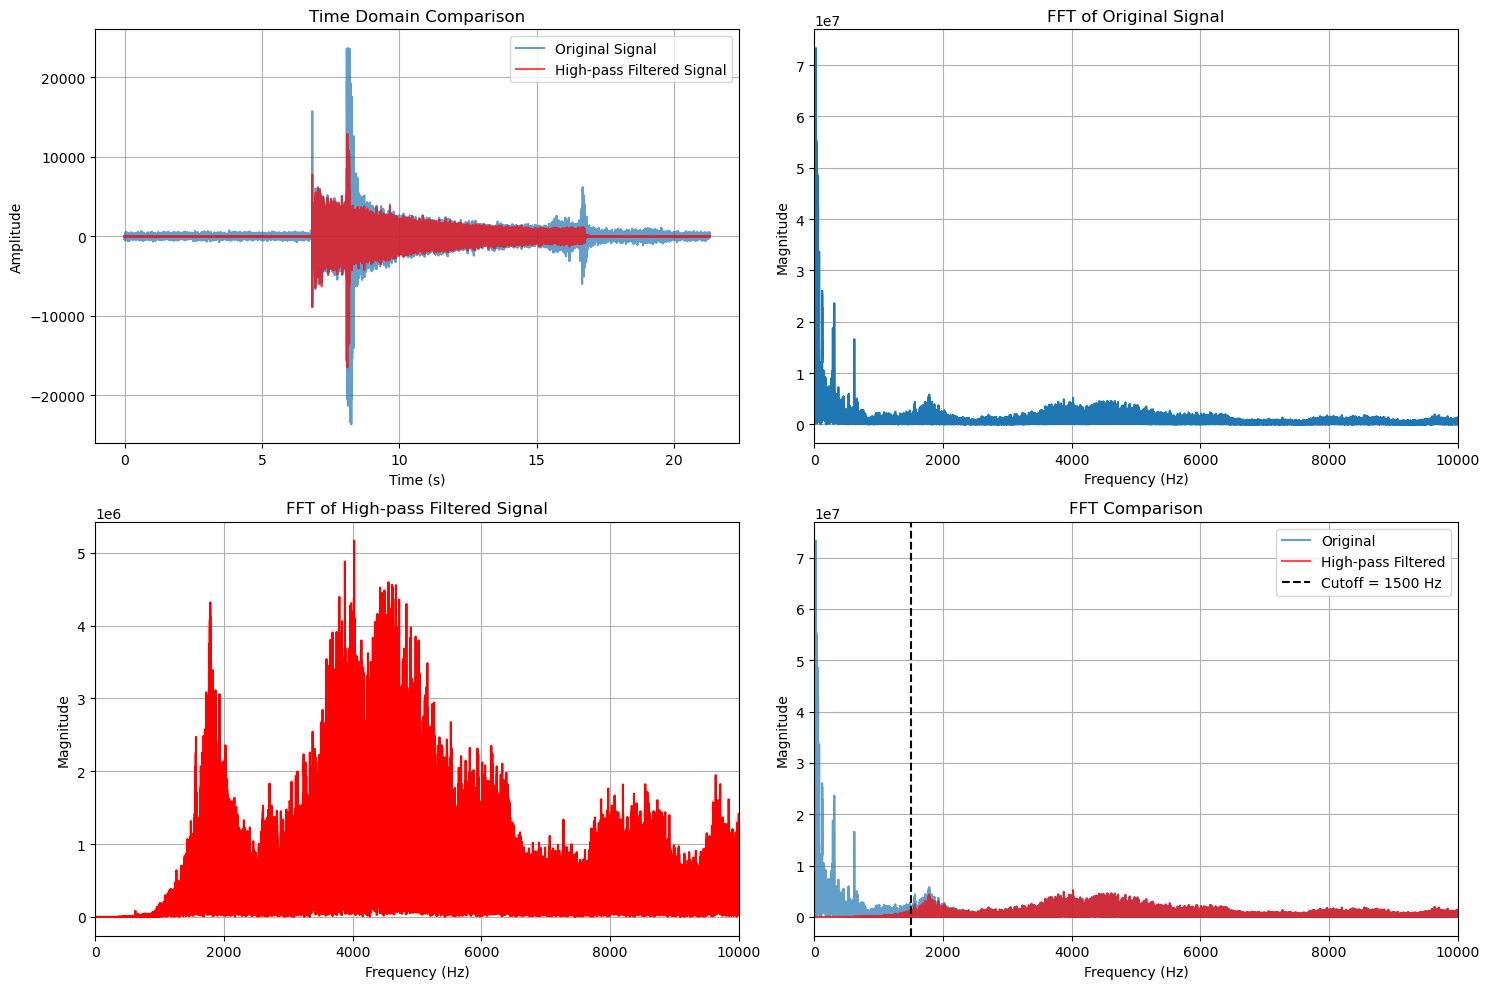

Sampling frequency: 48000.0 Hz
Cutoff frequency: 1500 Hz

Original signal:
  Low-frequency energy (<1500Hz): 1.00e+18
  High-frequency energy (≥1500Hz): 1.48e+17

Filtered signal:
  Low-frequency energy (<1500Hz): 8.15e+14
  High-frequency energy (≥1500Hz): 1.37e+17

Filtering performance:
  Low-frequency energy reduction: 99.9%
  High-frequency energy preservation: 92.4%


In [10]:
#Read the CSV file
file_path = os.path.join(Audio_path,"169.csv")
df = pd.read_csv(file_path)

# Extracting the 'Time' and 'M' columns
t = df['Time']
m = df['M']
#Calculate the sampling frequency from the time data
fs = 1 / (t[1] - t[0])              # Sampling frequency
cutoff = 1500               # Cutoff frequency in Hz

# Apply high-pass filter
m_filtered = highpass_filter(m, cutoff, fs, order=3)

# Calculate FFT - original signal and filtered signal
Y_original = np.fft.fft(m)
Y_filtered = np.fft.fft(m_filtered)
frequencies = np.fft.fftfreq(len(m), d=1/fs)

# Take only positive frequency components
pos_freq_idx = frequencies >= 0
frequencies_pos = frequencies[pos_freq_idx]
Y_original_pos = Y_original[pos_freq_idx]
Y_filtered_pos = Y_filtered[pos_freq_idx]

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Time domain comparison
axes[0, 0].plot(t, m, label='Original Signal', alpha=0.7)
axes[0, 0].plot(t, m_filtered, label='High-pass Filtered Signal', color='red', alpha=0.7)
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_title('Time Domain Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Frequency domain - original signal
axes[0, 1].plot(frequencies_pos, np.abs(Y_original_pos))
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Magnitude')
axes[0, 1].set_title('FFT of Original Signal')
axes[0, 1].set_xlim(0, 10000)  # Limit display range for better observation
axes[0, 1].grid(True)

# Frequency domain - filtered signal
axes[1, 0].plot(frequencies_pos, np.abs(Y_filtered_pos), color='red')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Magnitude')
axes[1, 0].set_title('FFT of High-pass Filtered Signal')
axes[1, 0].set_xlim(0, 10000)
axes[1, 0].grid(True)

# Frequency domain overlay comparison
axes[1, 1].plot(frequencies_pos, np.abs(Y_original_pos), label='Original', alpha=0.7)
axes[1, 1].plot(frequencies_pos, np.abs(Y_filtered_pos), label='High-pass Filtered', color='red', alpha=0.7)
axes[1, 1].axvline(x=cutoff, color='black', linestyle='--', label=f'Cutoff = {cutoff} Hz')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Magnitude')
axes[1, 1].set_title('FFT Comparison')
axes[1, 1].set_xlim(0, 10000)
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Analyze filtering performance
print(f"Sampling frequency: {fs:.1f} Hz")
print(f"Cutoff frequency: {cutoff} Hz")

# Calculate low-frequency and high-frequency energy
low_freq_mask = frequencies_pos < cutoff
high_freq_mask = frequencies_pos >= cutoff

# Low-frequency and high-frequency energy of original signal
low_energy_orig = np.sum(np.abs(Y_original_pos[low_freq_mask])**2)
high_energy_orig = np.sum(np.abs(Y_original_pos[high_freq_mask])**2)

# Low-frequency and high-frequency energy of filtered signal
low_energy_filt = np.sum(np.abs(Y_filtered_pos[low_freq_mask])**2)
high_energy_filt = np.sum(np.abs(Y_filtered_pos[high_freq_mask])**2)

print(f"\nOriginal signal:")
print(f"  Low-frequency energy (<{cutoff}Hz): {low_energy_orig:.2e}")
print(f"  High-frequency energy (≥{cutoff}Hz): {high_energy_orig:.2e}")

print(f"\nFiltered signal:")
print(f"  Low-frequency energy (<{cutoff}Hz): {low_energy_filt:.2e}")
print(f"  High-frequency energy (≥{cutoff}Hz): {high_energy_filt:.2e}")

print(f"\nFiltering performance:")
print(f"  Low-frequency energy reduction: {(1 - low_energy_filt/low_energy_orig)*100:.1f}%")
print(f"  High-frequency energy preservation: {(high_energy_filt/high_energy_orig)*100:.1f}%")

#### Apply high-pass filter on whole dataset(**audio_list_with_labels**)

In [11]:


cutoff = 1500  # Cutoff frequency in Hz
order = 3  # Filter order

Audio_list_high_pass = []

# Use tqdm to show process in real time
for audio_data in tqdm(audio_list_with_labels, desc="apply high-pass filter"):
    # Extract data from current audio sample
    audio_id = audio_data['id']
    df_audio = audio_data['audio'].copy()  # Use copy() to avoid modifying original data
    label = audio_data['label']
    
    # Calculate sampling frequency and apply filter
    t = df_audio['Time'].values
    m = df_audio['M'].values
    fs = 1 / (t[1] - t[0])  # Calculate sampling frequency
    m_filtered = highpass_filter(m, cutoff=cutoff, fs=fs, order=order)
    
    # Update the filtered data
    df_audio['M'] = m_filtered
    
    # Append to new list
    Audio_list_high_pass.append({
        'id': audio_id,
        'audio': df_audio,
        'label': label
    })

apply high-pass filter: 100%|██████████| 201/201 [00:26<00:00,  7.71it/s]


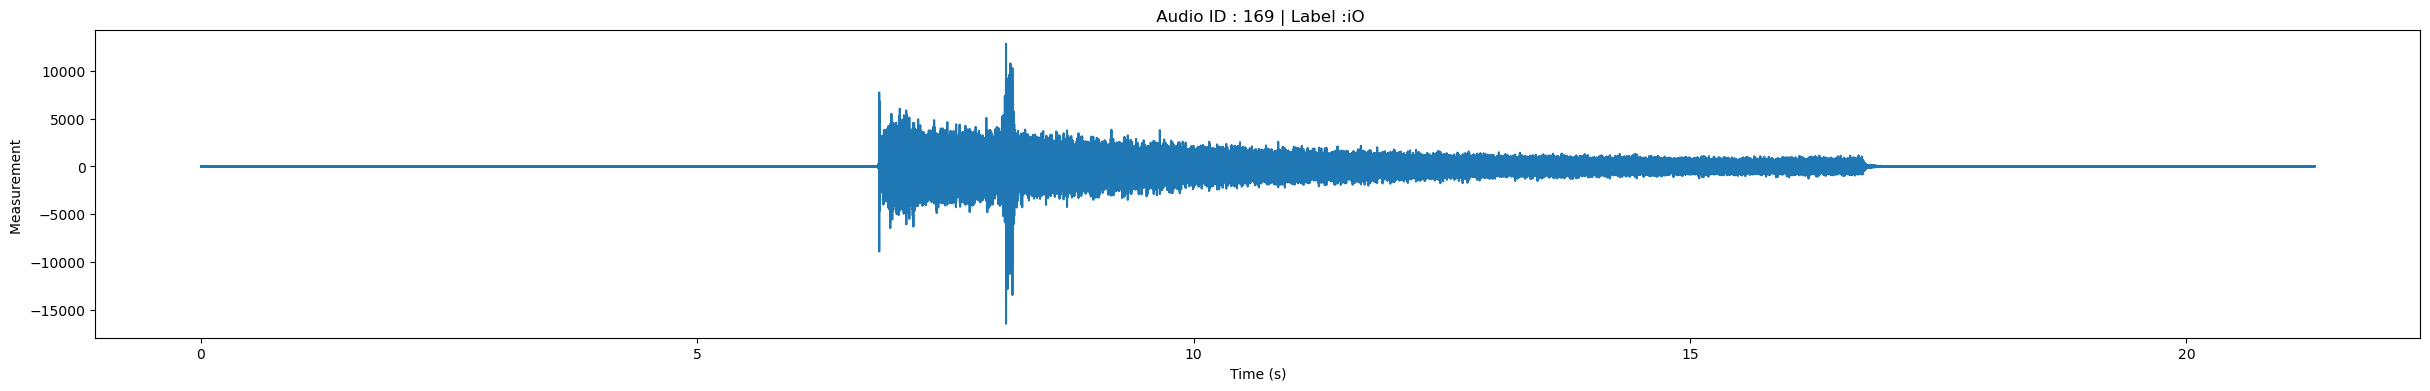

In [12]:
ReadSingleAudio(169,Audio_list_high_pass)

#### Denoise on the whole dataset

In [13]:
## audio_list_with_labels  as input
print("AUDIO NOISE REMOVAL - KEEPING ONLY EFFECTIVE TIME SEGMENTS")
# Process all audio files to remove noise
Audio_list_denoise = process_all_audio_effective(Audio_list_high_pass)


AUDIO NOISE REMOVAL - KEEPING ONLY EFFECTIVE TIME SEGMENTS
Processing 201 audio files...
Using THRESHOLD = 100
------------------------------------------------------------


Removing noise:  46%|████▋     | 93/201 [00:08<00:08, 13.17it/s]

Removing noise: 100%|██████████| 201/201 [00:16<00:00, 12.47it/s]


Processing Summary:
Original measurements: 201
Processed measurements: 200
Removed measurements (no effective signal): 1
Total original data points: 165,451,776
Total effective data points: 95,989,025
Data reduction: 42.0%


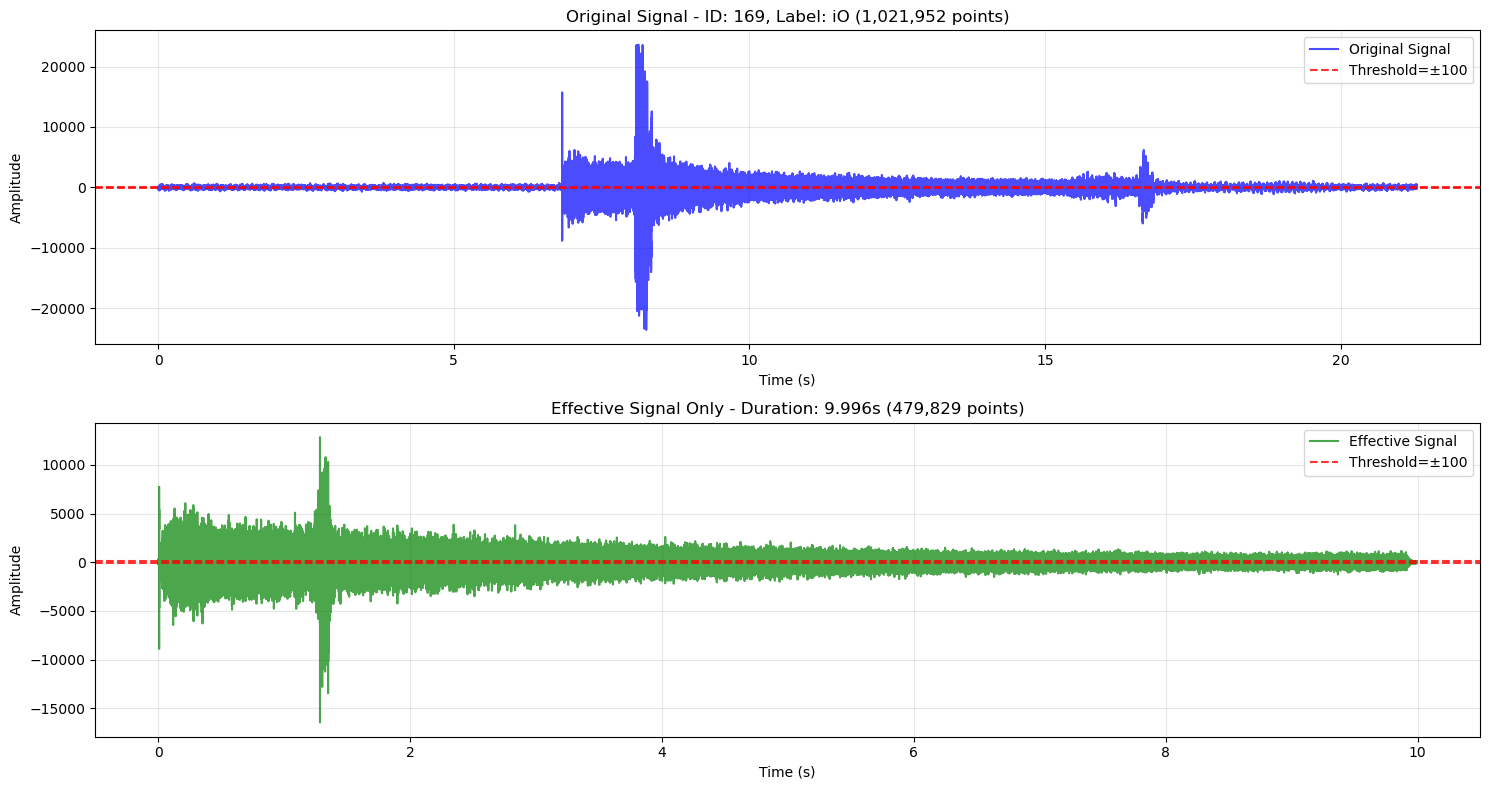


Comparison for Measurement 169:
Label: iO
Original duration: 21.291s (1,021,952 points)
Effective duration: 9.996s (479,829 points)
Data reduction: 53.0%


In [14]:
compare_before_after(169, audio_list_with_labels , Audio_list_denoise)

#### FFT an the whole datadet(**Audio_list_denoise**)

In [15]:
Audio_list_fft = apply_fft_to_audio_list(Audio_list_denoise)

Applying FFT to 200 audio files...


Apply FFT: 100%|██████████| 200/200 [00:31<00:00,  6.44it/s]


FFT processing complete! Successfully processed 200 audio files


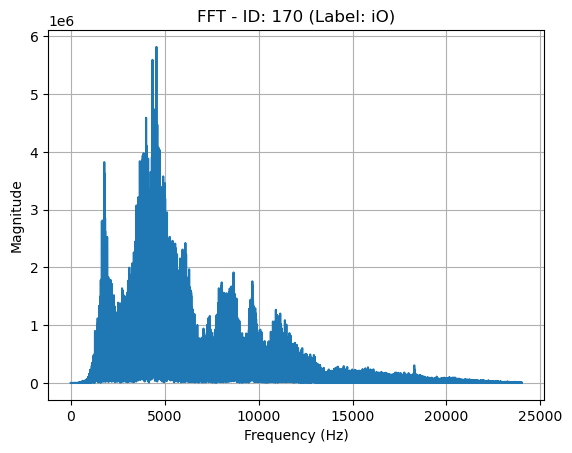

In [16]:
view_fft_data(Audio_list_fft,170)

# Feature Engineering and Cleansing

#### Time Domin

##### **Mean**

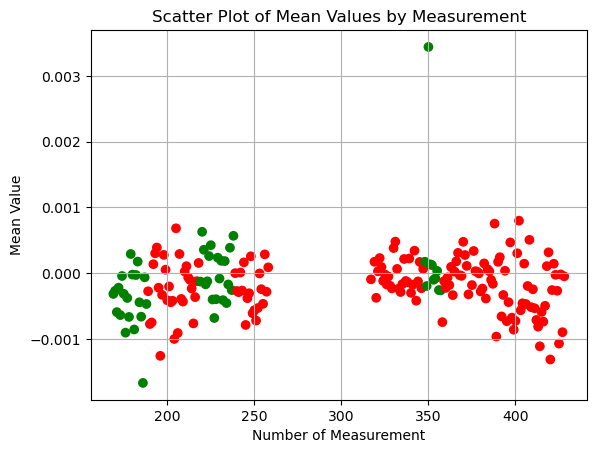

In [ ]:
mean_list_filtered = [audio_data["audio"]["M"].values.mean() for audio_data in Audio_list_denoise]
id = [audio_data["id"] for audio_data in Audio_list_denoise]
label = [audio_data['label'] for audio_data in Audio_list_denoise]
mean_df = pd.DataFrame({
    "Number of Measurement": id,
    "Mean": mean_list_filtered,
    "Label": label
})
# Create color mapping for datasets
colors = mean_df['Label'].map({'iO': 'green', 'niO': 'red'})
# Audio means
plt.scatter(mean_df["Number of Measurement"], 
           mean_df["Mean"], 
           c=colors, 
           )

plt.xlabel('Number of Measurement')
plt.ylabel('Mean Value')
plt.title('Scatter Plot of Mean Values by Measurement')
plt.grid(True)

"""
mean_list_filtered = [audio_data["audio"]["M"].values.mean() for audio_data in audio_list_with_labels   ]
id = [audio_data["id"] for audio_data in audio_list_with_labels]
label = [audio_data['label'] for audio_data in audio_list_with_labels]
mean_df = pd.DataFrame({
    "Number of Measurement": id,
    "Mean": mean_list_filtered,
    "Label": label
})
# Create color mapping for datasets
colors = mean_df['Label'].map({'iO': 'green', 'niO': 'red'})
# Audio means
plt.scatter(mean_df["Number of Measurement"], 
           mean_df["Mean"], 
           c=colors, 
           )

plt.xlabel('Number of Measurement')
plt.ylabel('Mean Value')
plt.title('Scatter Plot of Mean Values by Measurement')
plt.grid(True)
"""

##### **Std**

'\nstd_list_filtered = [audio_data["audio"]["M"].values.std() for audio_data in audio_list_with_labels]\nid = [audio_data["id"] for audio_data in audio_list_with_labels]\nlabel = [audio_data[\'label\'] for audio_data in audio_list_with_labels]\n\nStd_df = pd.DataFrame({\n   "Number of Measurement": id,\n   "Std": std_list_filtered,\n   "Label": label\n})\n\n# Create color mapping for datasets\ncolors = Std_df[\'Label\'].map({\'iO\': \'green\', \'niO\': \'red\'})\n\n# Audio std\nplt.scatter(Std_df["Number of Measurement"],\n           Std_df["Std"],\n           c=colors,\n           )\n\nplt.xlabel(\'Number of Measurement\')\nplt.ylabel(\'Std Value\')\nplt.title(\'Scatter Plot of Std Values by Measurement\')\nplt.grid(True)\n'

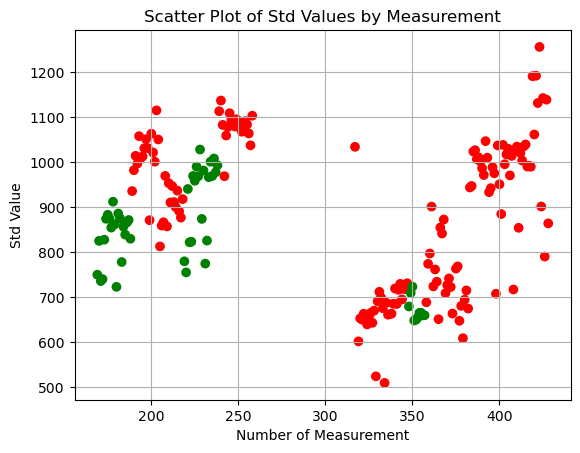

In [20]:
std_list_filtered = [audio_data["audio"]["M"].values.std() for audio_data in Audio_list_denoise]
id = [audio_data["id"] for audio_data in Audio_list_denoise]
label = [audio_data['label'] for audio_data in Audio_list_denoise]

Std_df = pd.DataFrame({
   "Number of Measurement": id,
   "Std": std_list_filtered,
   "Label": label
})

# Create color mapping for datasets
colors = Std_df['Label'].map({'iO': 'green', 'niO': 'red'})

# Audio std
plt.scatter(Std_df["Number of Measurement"],
           Std_df["Std"],
           c=colors,
           )

plt.xlabel('Number of Measurement')
plt.ylabel('Std Value')
plt.title('Scatter Plot of Std Values by Measurement')
plt.grid(True)

"""
std_list_filtered = [audio_data["audio"]["M"].values.std() for audio_data in audio_list_with_labels]
id = [audio_data["id"] for audio_data in audio_list_with_labels]
label = [audio_data['label'] for audio_data in audio_list_with_labels]

Std_df = pd.DataFrame({
   "Number of Measurement": id,
   "Std": std_list_filtered,
   "Label": label
})

# Create color mapping for datasets
colors = Std_df['Label'].map({'iO': 'green', 'niO': 'red'})

# Audio std
plt.scatter(Std_df["Number of Measurement"],
           Std_df["Std"],
           c=colors,
           )

plt.xlabel('Number of Measurement')
plt.ylabel('Std Value')
plt.title('Scatter Plot of Std Values by Measurement')
plt.grid(True)
"""


##### **RMS**

In [ ]:
rms_list_filtered = [np.sqrt(np.mean(audio_data["audio"]["M"].values**2)) for audio_data in Audio_list_denoise]
id = [audio_data["id"] for audio_data in Audio_list_denoise]
label = [audio_data['label'] for audio_data in Audio_list_denoise]

Rms_df = pd.DataFrame({
  "Number of Measurement": id,
  "RMS": rms_list_filtered,
  "Label": label
})

# Create color mapping for datasets
colors = Rms_df['Label'].map({'iO': 'green', 'niO': 'red'})

# Audio Rms
plt.scatter(Rms_df["Number of Measurement"],
          Rms_df["RMS"],
          c=colors,
          )

plt.xlabel('Number of Measurement')
plt.ylabel('RMS Value')
plt.title('Scatter Plot of RMS Values by Measurement')
plt.grid(True)

##### **Duration time of weld process**

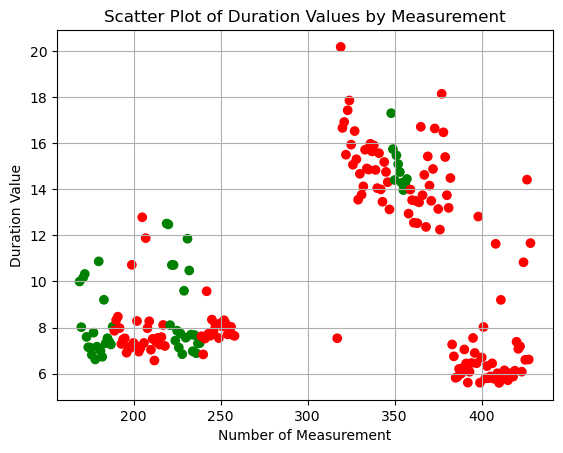

In [ ]:
duration_list_filtered = calculate_duration(Audio_list_denoise)
id = [audio_data["id"] for audio_data in Audio_list_denoise]
label = [audio_data['label'] for audio_data in Audio_list_denoise]

Duration_df = pd.DataFrame({
  "Number of Measurement": id,
  "Duration": duration_list_filtered,
  "Label": label
})

# Create color mapping for datasets
colors = Duration_df['Label'].map({'iO': 'green', 'niO': 'red'})

# Audio Duration
plt.scatter(Duration_df["Number of Measurement"],
          Duration_df["Duration"],
          c=colors,
          )

plt.xlabel('Number of Measurement')
plt.ylabel('Duration Value')
plt.title('Scatter Plot of Duration Values by Measurement')
plt.grid(True)

##### **Peak Shift**

Definition: The relative position of the maximum amplitude within the active duration, normalized to 0-1 scale.

    0.0: Peak at beginning of active region (front-loaded)

    0.5: Peak at middle of active region (centered)

    1.0: Peak at end of active region (back-loaded)

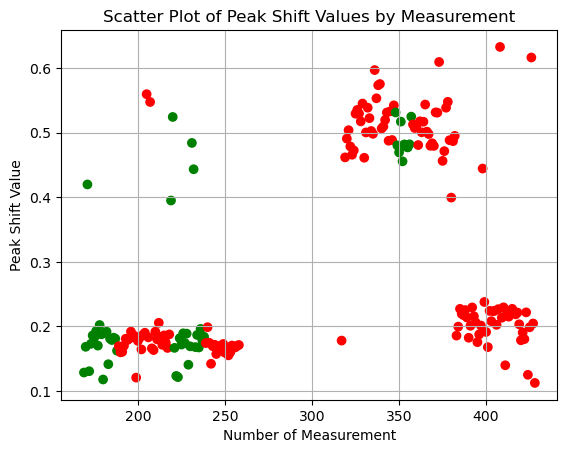

In [27]:
peak_shift_list_filtered = calculate_peak_shift(Audio_list_denoise)
id = [audio_data["id"] for audio_data in Audio_list_denoise]
label = [audio_data['label'] for audio_data in Audio_list_denoise]

Peak_shift_df = pd.DataFrame({
  "Number of Measurement": id,
  "Peak_shift": peak_shift_list_filtered,
  "Label": label
})

# Create color mapping for datasets
colors = Peak_shift_df['Label'].map({'iO': 'green', 'niO': 'red'})

# Audio Peak shift
plt.scatter(Peak_shift_df["Number of Measurement"],
          Peak_shift_df["Peak_shift"],
          c=colors,
          )

plt.xlabel('Number of Measurement')
plt.ylabel('Peak Shift Value')
plt.title('Scatter Plot of Peak Shift Values by Measurement')
plt.grid(True)

##### **Zero Cross Rate**

Calculating ZCR for 200 files...


100%|██████████| 200/200 [00:01<00:00, 121.57it/s]


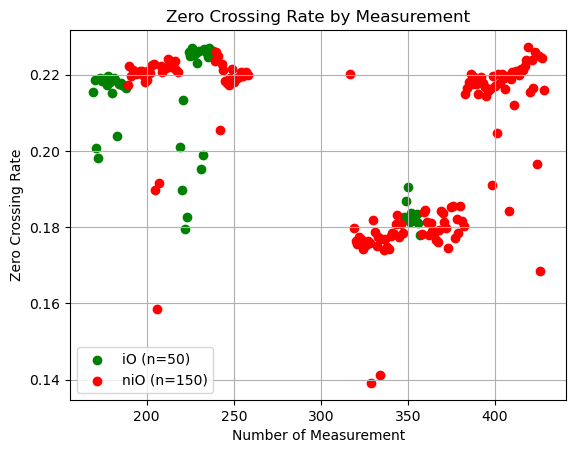

In [40]:
zcr_df = analyze_all_zcr(Audio_list_denoise)
color_map = {'iO': 'green', 'niO': 'red'}
for label in zcr_df['Label'].unique():
        subset = zcr_df[zcr_df['Label'] == label]
        color = color_map.get(label, 'blue')
        plt.scatter(subset['Number of Measurement'], subset['ZCR'],
                    color=color, label=f'{label} (n={len(subset)})')
plt.xlabel('Number of Measurement')
plt.ylabel('Zero Crossing Rate')
plt.title('Zero Crossing Rate by Measurement')
plt.legend()
plt.grid(True)

##### **Skewness and kurtosis**

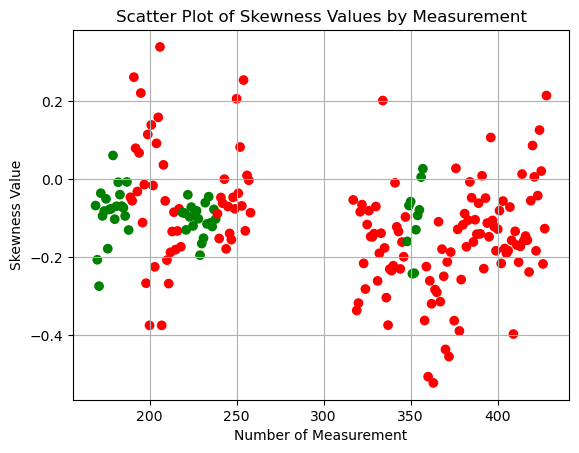

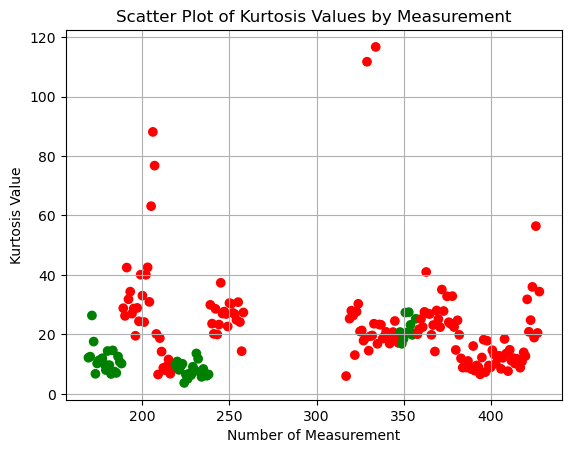

In [34]:
skewness_list_filtered, kurtosis_list_filtered = calculate_skewness_kurtosis(Audio_list_denoise)
id = [audio_data["id"] for audio_data in Audio_list_denoise]
label = [audio_data['label'] for audio_data in Audio_list_denoise]

Skewness_df = pd.DataFrame({
  "Number of Measurement": id,
  "Skewness": skewness_list_filtered,
  "Label": label
})

# Create color mapping for datasets
colors = Skewness_df['Label'].map({'iO': 'green', 'niO': 'red'})

# Audio Skewness
plt.scatter(Skewness_df["Number of Measurement"],
          Skewness_df["Skewness"],
          c=colors,
          )

plt.xlabel('Number of Measurement')
plt.ylabel('Skewness Value')
plt.title('Scatter Plot of Skewness Values by Measurement')
plt.grid(True)

# Audio Kurtosis
Kurtosis_df = pd.DataFrame({
  "Number of Measurement": id,
  "Kurtosis": kurtosis_list_filtered,
  "Label": label
})

colors = Kurtosis_df['Label'].map({'iO': 'green', 'niO': 'red'})

plt.figure()
plt.scatter(Kurtosis_df["Number of Measurement"],
          Kurtosis_df["Kurtosis"],
          c=colors,
          )

plt.xlabel('Number of Measurement')
plt.ylabel('Kurtosis Value')
plt.title('Scatter Plot of Kurtosis Values by Measurement')
plt.grid(True)

##### Merge

In [45]:
# Print column headers for checking
print("mean_df columns:", mean_df.columns.tolist())
print("Std_df columns:", Std_df.columns.tolist())
print("Rms_df columns:", Rms_df.columns.tolist())
print("Duration_df columns:", Duration_df.columns.tolist())
print("Peak_shift_df columns:", Peak_shift_df.columns.tolist())
print("zcr_df columns:", zcr_df.columns.tolist())
print("Skewness_df columns:", Skewness_df.columns.tolist())
print("Kurtosis_df columns:", Kurtosis_df.columns.tolist())

# Merge all features based on id and label
features_df = pd.merge(mean_df, Std_df[['Number of Measurement', 'Std']], on='Number of Measurement', how='left')
features_df = pd.merge(features_df, Rms_df[['Number of Measurement', 'RMS']], on='Number of Measurement', how='left')
features_df = pd.merge(features_df, Duration_df[['Number of Measurement', 'Duration']], on='Number of Measurement', how='left')
features_df = pd.merge(features_df, Peak_shift_df[['Number of Measurement', 'Peak_shift']], on='Number of Measurement', how='left')
features_df = pd.merge(features_df, zcr_df[['Number of Measurement', 'ZCR']], on='Number of Measurement', how='left')
features_df = pd.merge(features_df, Skewness_df[['Number of Measurement', 'Skewness']], on='Number of Measurement', how='left')
features_df = pd.merge(features_df, Kurtosis_df[['Number of Measurement', 'Kurtosis']], on='Number of Measurement', how='left')

# Drop duplicate column from zcr merge
features_df = features_df
features_df_time = features_df

print(features_df_time.head())

mean_df columns: ['Number of Measurement', 'Mean', 'Label']
Std_df columns: ['Number of Measurement', 'Std', 'Label']
Rms_df columns: ['Number of Measurement', 'RMS', 'Label']
Duration_df columns: ['Number of Measurement', 'Duration', 'Label']
Peak_shift_df columns: ['Number of Measurement', 'Peak_shift', 'Label']
zcr_df columns: ['Number of Measurement', 'ZCR', 'Label']
Skewness_df columns: ['Number of Measurement', 'Skewness', 'Label']
Kurtosis_df columns: ['Number of Measurement', 'Kurtosis', 'Label']
   Number of Measurement      Mean Label         Std         RMS   Duration  \
0                    169 -0.011418    iO  749.951901  749.951901   9.996417   
1                    170  0.014857    iO  825.232658  825.232658   8.017437   
2                    171  0.057396    iO  735.846062  735.846062  10.160021   
3                    172 -0.172601    iO  740.132735  740.132735  10.324646   
4                    173 -0.183890    iO  827.916774  827.916774   7.596188   

   Peak_shift  

#### Frequency Domin

##### **Spectral Centroid**

The Spectral Centroid is a fundamental audio feature that represents the "center of mass" of the spectrum. It indicates where the energy of a signal is concentrated in the frequency domain and is often used as a measure of the "brightness" or "timbre" of an audio signal.

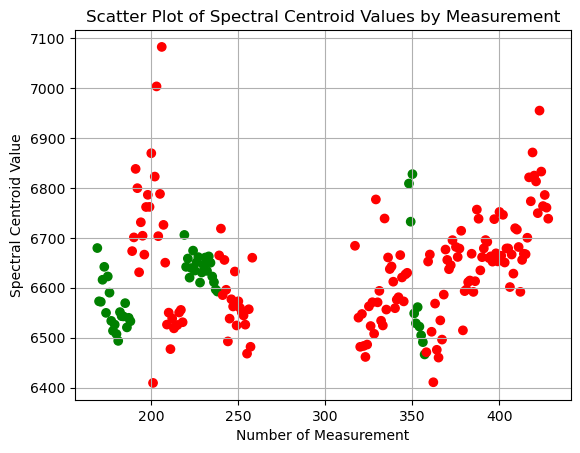

In [50]:
def calculate_spectral_centroid(audio_list_fft):
   """
   Calculate spectral centroid for each audio data in FFT format
   """
   spectral_centroid_list = []
   
   for audio_data in audio_list_fft:
       df_fft = audio_data["audio"]
       frequencies = df_fft['Frequency'].values
       magnitudes = df_fft['FFT_Magnitude'].values
       
       # Calculate spectral centroid
       spectral_centroid = np.sum(frequencies * magnitudes) / np.sum(magnitudes)
       spectral_centroid_list.append(spectral_centroid)
   
   return spectral_centroid_list

spectral_centroid_list_filtered = calculate_spectral_centroid(Audio_list_fft)
id = [audio_data["id"] for audio_data in Audio_list_fft]
label = [audio_data['label'] for audio_data in Audio_list_fft]

Spectral_centroid_df = pd.DataFrame({
  "Number of Measurement": id,
  "Spectral_Centroid": spectral_centroid_list_filtered,
  "Label": label
})

# Create color mapping for datasets
colors = Spectral_centroid_df['Label'].map({'iO': 'green', 'niO': 'red'})
#plt.figure(figsize=(15, 5))
# Audio Spectral Centroid
plt.scatter(Spectral_centroid_df["Number of Measurement"],
          Spectral_centroid_df["Spectral_Centroid"],
          c=colors,
          )

plt.xlabel('Number of Measurement')
plt.ylabel('Spectral Centroid Value')
plt.title('Scatter Plot of Spectral Centroid Values by Measurement')
plt.grid(True)

##### **Domin Frequency**

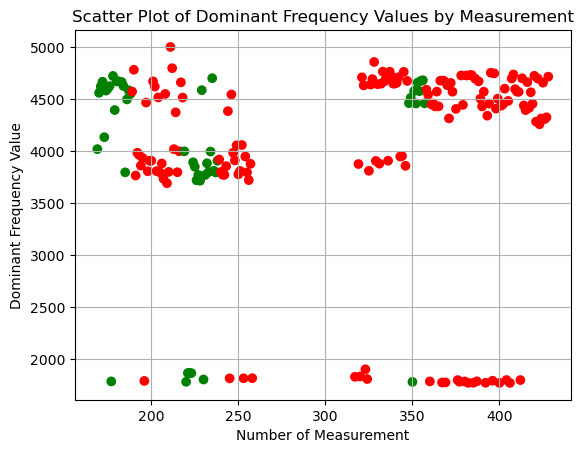

In [47]:
def calculate_dominant_frequency(audio_list_fft):
   """
   Calculate dominant frequency for each audio data in FFT format
   """
   dominant_frequency_list = []
   
   for audio_data in audio_list_fft:
       df_fft = audio_data["audio"]
       frequencies = df_fft['Frequency'].values
       magnitudes = df_fft['FFT_Magnitude'].values
       
       # Find dominant frequency (frequency with maximum magnitude)
       max_magnitude_idx = np.argmax(magnitudes)
       dominant_frequency = frequencies[max_magnitude_idx]
       dominant_frequency_list.append(dominant_frequency)
   
   return dominant_frequency_list

dominant_frequency_list_filtered = calculate_dominant_frequency(Audio_list_fft)
id = [audio_data["id"] for audio_data in Audio_list_fft]
label = [audio_data['label'] for audio_data in Audio_list_fft]

Dominant_frequency_df = pd.DataFrame({
  "Number of Measurement": id,
  "Dominant_Frequency": dominant_frequency_list_filtered,
  "Label": label
})

# Create color mapping for datasets
colors = Dominant_frequency_df['Label'].map({'iO': 'green', 'niO': 'red'})

# Audio Dominant Frequency
plt.scatter(Dominant_frequency_df["Number of Measurement"],
          Dominant_frequency_df["Dominant_Frequency"],
          c=colors,
          )

plt.xlabel('Number of Measurement')
plt.ylabel('Dominant Frequency Value')
plt.title('Scatter Plot of Dominant Frequency Values by Measurement')
plt.grid(True)

##### **Band Energy Ratio, BER**

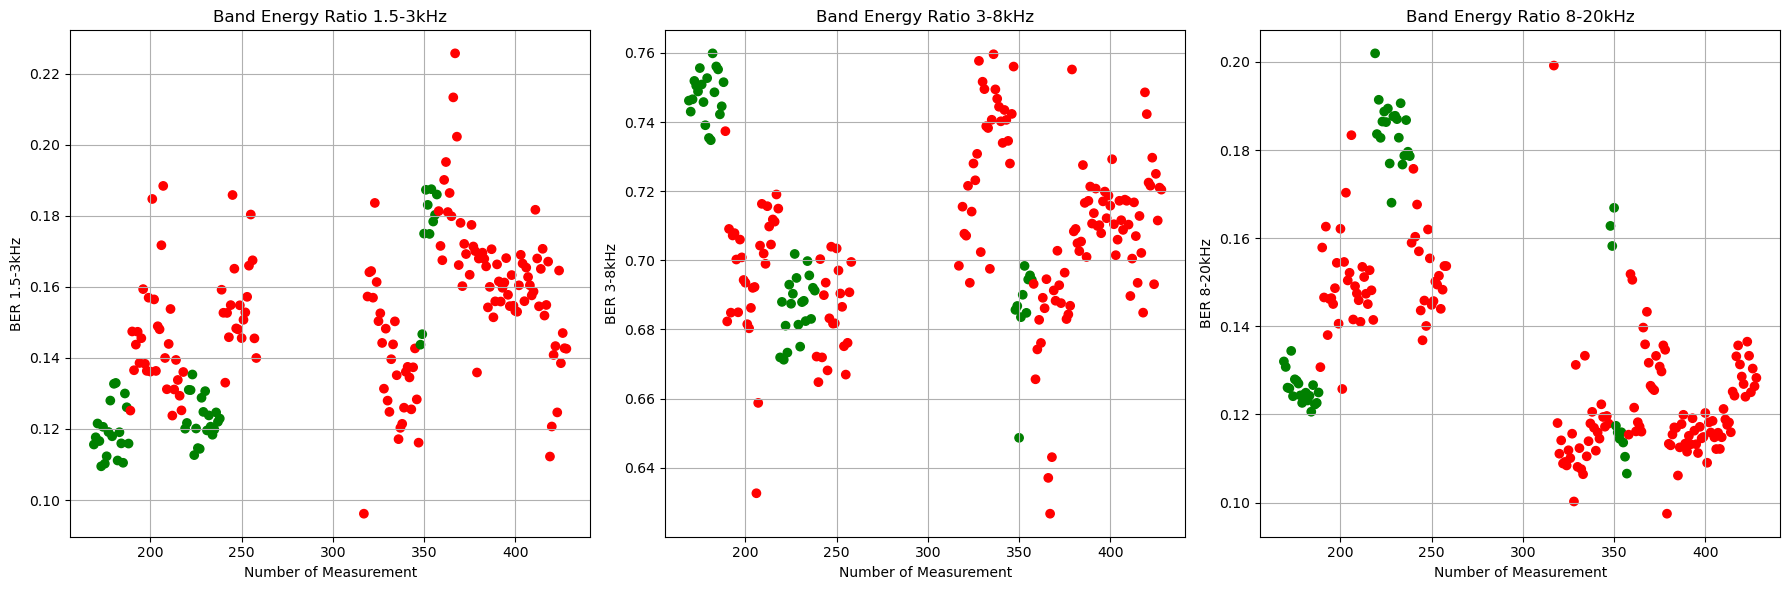

In [54]:
def calculate_band_energy_ratio(audio_list_fft, band_ranges=[(1500, 3000), (3000, 8000), (8000, 20000)]):
   """
   Calculate band energy ratio for each audio data in FFT format
   """
   band_energy_ratio_list = []
   
   for audio_data in audio_list_fft:
       df_fft = audio_data["audio"]
       frequencies = df_fft['Frequency'].values
       magnitudes = df_fft['FFT_Magnitude'].values
       
       # Calculate total energy
       total_energy = np.sum(magnitudes**2)
       
       # Calculate energy for each band
       band_ratios = []
       for low_freq, high_freq in band_ranges:
           band_mask = (frequencies >= low_freq) & (frequencies <= high_freq)
           band_energy = np.sum(magnitudes[band_mask]**2)
           
           if total_energy > 0:
               band_ratio = band_energy / total_energy
           else:
               band_ratio = 0
           
           band_ratios.append(band_ratio)
       
       band_energy_ratio_list.append(band_ratios)
   
   return band_energy_ratio_list

# 调用时自由设定频段
band_energy_ratio_list_filtered = calculate_band_energy_ratio(Audio_list_fft, band_ranges=[(1500, 3000), (3000, 8000), (8000, 20000)])
id = [audio_data["id"] for audio_data in Audio_list_fft]
label = [audio_data['label'] for audio_data in Audio_list_fft]

# Create DataFrame for each band
Band_energy_ratio_df = pd.DataFrame({
  "Number of Measurement": id,
  "BER_1.5-3kHz": [ratios[0] for ratios in band_energy_ratio_list_filtered],
  "BER_3-8kHz": [ratios[1] for ratios in band_energy_ratio_list_filtered],
  "BER_8-20kHz": [ratios[2] for ratios in band_energy_ratio_list_filtered],
  "Label": label
})

# Create color mapping for datasets
colors = Band_energy_ratio_df['Label'].map({'iO': 'green', 'niO': 'red'})

# Plot each band
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# BER 1.5-3kHz
axes[0].scatter(Band_energy_ratio_df["Number of Measurement"],
              Band_energy_ratio_df["BER_1.5-3kHz"],
              c=colors)
axes[0].set_xlabel('Number of Measurement')
axes[0].set_ylabel('BER 1.5-3kHz')
axes[0].set_title('Band Energy Ratio 1.5-3kHz')
axes[0].grid(True)

# BER 3-8kHz
axes[1].scatter(Band_energy_ratio_df["Number of Measurement"],
              Band_energy_ratio_df["BER_3-8kHz"],
              c=colors)
axes[1].set_xlabel('Number of Measurement')
axes[1].set_ylabel('BER 3-8kHz')
axes[1].set_title('Band Energy Ratio 3-8kHz')
axes[1].grid(True)

# BER 8-20kHz
axes[2].scatter(Band_energy_ratio_df["Number of Measurement"],
              Band_energy_ratio_df["BER_8-20kHz"],
              c=colors)
axes[2].set_xlabel('Number of Measurement')
axes[2].set_ylabel('BER 8-20kHz')
axes[2].set_title('Band Energy Ratio 8-20kHz')
axes[2].grid(True)

plt.tight_layout()
plt.show()

##### **Peak Amplitude**

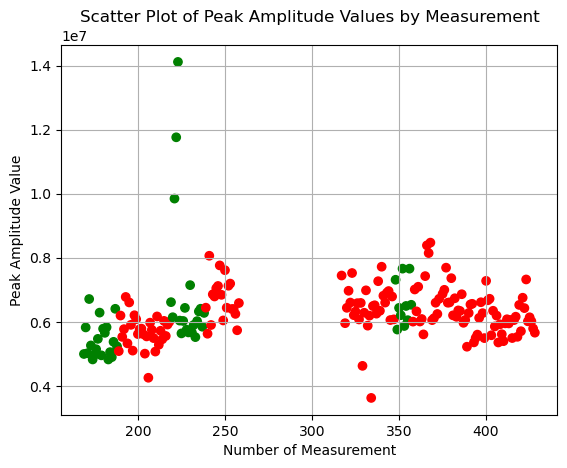

In [56]:
def calculate_peak_amplitude(audio_list_fft):
   """
   Calculate peak amplitude for each audio data in FFT format
   """
   peak_amplitude_list = []
   
   for audio_data in audio_list_fft:
       df_fft = audio_data["audio"]
       magnitudes = df_fft['FFT_Magnitude'].values
       
       # Find peak amplitude
       peak_amplitude = np.max(magnitudes)
       peak_amplitude_list.append(peak_amplitude)
   
   return peak_amplitude_list

peak_amplitude_list_filtered = calculate_peak_amplitude(Audio_list_fft)
id = [audio_data["id"] for audio_data in Audio_list_fft]
label = [audio_data['label'] for audio_data in Audio_list_fft]

Peak_amplitude_df = pd.DataFrame({
  "Number of Measurement": id,
  "Peak_Amplitude": peak_amplitude_list_filtered,
  "Label": label
})

# Create color mapping for datasets
colors = Peak_amplitude_df['Label'].map({'iO': 'green', 'niO': 'red'})

# Audio Peak Amplitude
plt.scatter(Peak_amplitude_df["Number of Measurement"],
          Peak_amplitude_df["Peak_Amplitude"],
          c=colors,
          )

plt.xlabel('Number of Measurement')
plt.ylabel('Peak Amplitude Value')
plt.title('Scatter Plot of Peak Amplitude Values by Measurement')
plt.grid(True)

##### **Spectral Energy**

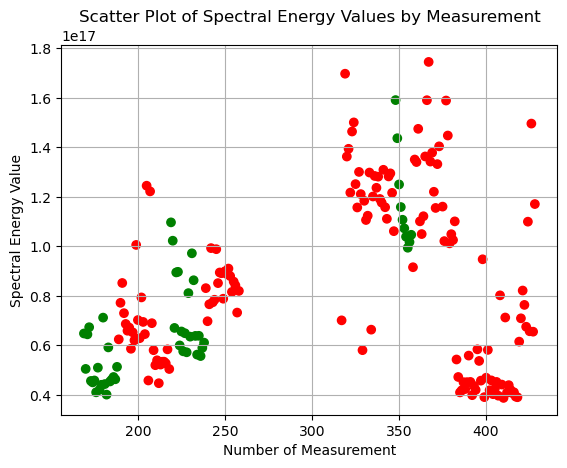

In [57]:
def calculate_spectral_energy(audio_list_fft):
   """
   Calculate spectral energy for each audio data in FFT format
   """
   spectral_energy_list = []
   
   for audio_data in audio_list_fft:
       df_fft = audio_data["audio"]
       magnitudes = df_fft['FFT_Magnitude'].values
       
       # Calculate spectral energy (sum of squared magnitudes)
       spectral_energy = np.sum(magnitudes**2)
       spectral_energy_list.append(spectral_energy)
   
   return spectral_energy_list

spectral_energy_list_filtered = calculate_spectral_energy(Audio_list_fft)
id = [audio_data["id"] for audio_data in Audio_list_fft]
label = [audio_data['label'] for audio_data in Audio_list_fft]

Spectral_energy_df = pd.DataFrame({
  "Number of Measurement": id,
  "Spectral_Energy": spectral_energy_list_filtered,
  "Label": label
})

# Create color mapping for datasets
colors = Spectral_energy_df['Label'].map({'iO': 'green', 'niO': 'red'})

# Audio Spectral Energy
plt.scatter(Spectral_energy_df["Number of Measurement"],
          Spectral_energy_df["Spectral_Energy"],
          c=colors,
          )

plt.xlabel('Number of Measurement')
plt.ylabel('Spectral Energy Value')
plt.title('Scatter Plot of Spectral Energy Values by Measurement')
plt.grid(True)

##### **Spectral Flatness**

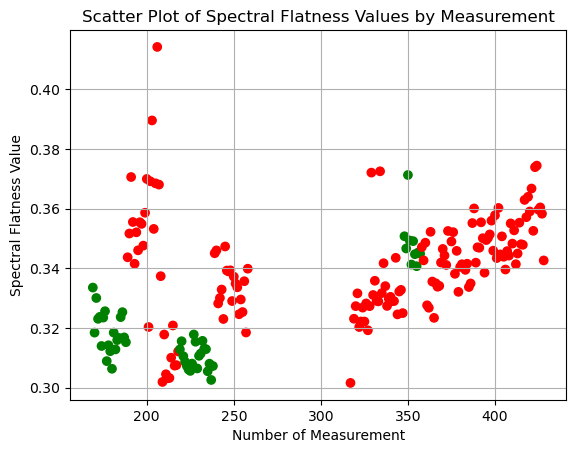

In [58]:
def calculate_spectral_flatness(audio_list_fft):
   """
   Calculate spectral flatness for each audio data in FFT format
   """
   spectral_flatness_list = []
   
   for audio_data in audio_list_fft:
       df_fft = audio_data["audio"]
       magnitudes = df_fft['FFT_Magnitude'].values
       
       # Remove zero values to avoid log(0)
       magnitudes = magnitudes[magnitudes > 0]
       
       if len(magnitudes) > 0:
           # Calculate spectral flatness: geometric mean / arithmetic mean
           geometric_mean = np.exp(np.mean(np.log(magnitudes)))
           arithmetic_mean = np.mean(magnitudes)
           
           if arithmetic_mean > 0:
               spectral_flatness = geometric_mean / arithmetic_mean
           else:
               spectral_flatness = 0
       else:
           spectral_flatness = 0
       
       spectral_flatness_list.append(spectral_flatness)
   
   return spectral_flatness_list

spectral_flatness_list_filtered = calculate_spectral_flatness(Audio_list_fft)
id = [audio_data["id"] for audio_data in Audio_list_fft]
label = [audio_data['label'] for audio_data in Audio_list_fft]

Spectral_flatness_df = pd.DataFrame({
  "Number of Measurement": id,
  "Spectral_Flatness": spectral_flatness_list_filtered,
  "Label": label
})

# Create color mapping for datasets
colors = Spectral_flatness_df['Label'].map({'iO': 'green', 'niO': 'red'})

# Audio Spectral Flatness
plt.scatter(Spectral_flatness_df["Number of Measurement"],
          Spectral_flatness_df["Spectral_Flatness"],
          c=colors,
          )

plt.xlabel('Number of Measurement')
plt.ylabel('Spectral Flatness Value')
plt.title('Scatter Plot of Spectral Flatness Values by Measurement')
plt.grid(True)

##### **Spectral Entropy**

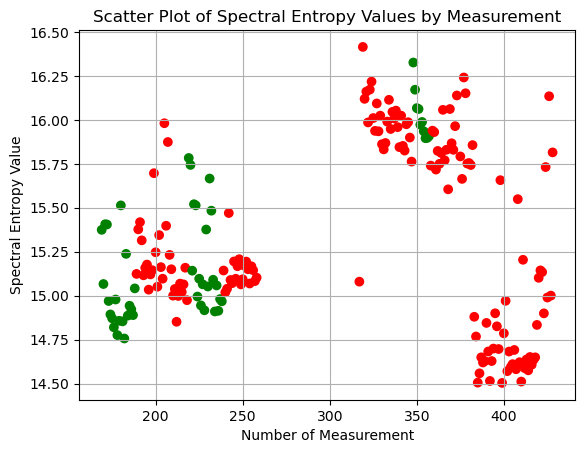

In [59]:
def calculate_spectral_entropy(audio_list_fft):
   """
   Calculate spectral entropy for each audio data in FFT format
   """
   spectral_entropy_list = []
   
   for audio_data in audio_list_fft:
       df_fft = audio_data["audio"]
       magnitudes = df_fft['FFT_Magnitude'].values
       
       # Calculate power spectral density
       power = magnitudes**2
       
       # Normalize to create probability distribution
       total_power = np.sum(power)
       
       if total_power > 0:
           prob_dist = power / total_power
           
           # Remove zero values to avoid log(0)
           prob_dist = prob_dist[prob_dist > 0]
           
           if len(prob_dist) > 0:
               # Calculate spectral entropy
               spectral_entropy = -np.sum(prob_dist * np.log2(prob_dist))
           else:
               spectral_entropy = 0
       else:
           spectral_entropy = 0
       
       spectral_entropy_list.append(spectral_entropy)
   
   return spectral_entropy_list

spectral_entropy_list_filtered = calculate_spectral_entropy(Audio_list_fft)
id = [audio_data["id"] for audio_data in Audio_list_fft]
label = [audio_data['label'] for audio_data in Audio_list_fft]

Spectral_entropy_df = pd.DataFrame({
  "Number of Measurement": id,
  "Spectral_Entropy": spectral_entropy_list_filtered,
  "Label": label
})

# Create color mapping for datasets
colors = Spectral_entropy_df['Label'].map({'iO': 'green', 'niO': 'red'})

# Audio Spectral Entropy
plt.scatter(Spectral_entropy_df["Number of Measurement"],
          Spectral_entropy_df["Spectral_Entropy"],
          c=colors,
          )

plt.xlabel('Number of Measurement')
plt.ylabel('Spectral Entropy Value')
plt.title('Scatter Plot of Spectral Entropy Values by Measurement')
plt.grid(True)

##### **Merge**

In [63]:
# Print column headers for checking
print("Spectral_centroid_df columns:", Spectral_centroid_df.columns.tolist())
print("Spectral_energy_df columns:", Spectral_energy_df.columns.tolist())
print("Spectral_entropy_df columns:", Spectral_entropy_df.columns.tolist())
print("Spectral_flatness_df columns:", Spectral_flatness_df.columns.tolist())
print("Peak_amplitude_df columns:", Peak_amplitude_df.columns.tolist())
print("Dominant_frequency_df columns:", Dominant_frequency_df.columns.tolist())

# Merge all spectral features based on id and label
spectral_features_df = pd.merge(Spectral_centroid_df, Spectral_energy_df[['Number of Measurement', 'Spectral_Energy']], on='Number of Measurement', how='left')
spectral_features_df = pd.merge(spectral_features_df, Spectral_entropy_df[['Number of Measurement', 'Spectral_Entropy']], on='Number of Measurement', how='left')
spectral_features_df = pd.merge(spectral_features_df, Spectral_flatness_df[['Number of Measurement', 'Spectral_Flatness']], on='Number of Measurement', how='left')
spectral_features_df = pd.merge(spectral_features_df, Peak_amplitude_df[['Number of Measurement', 'Peak_Amplitude']], on='Number of Measurement', how='left')
spectral_features_df = pd.merge(spectral_features_df, Dominant_frequency_df[['Number of Measurement', 'Dominant_Frequency']], on='Number of Measurement', how='left')

features_df_freq = spectral_features_df

print(features_df_freq.head())

Spectral_centroid_df columns: ['Number of Measurement', 'Spectral_Centroid', 'Label']
Spectral_energy_df columns: ['Number of Measurement', 'Spectral_Energy', 'Label']
Spectral_entropy_df columns: ['Number of Measurement', 'Spectral_Entropy', 'Label']
Spectral_flatness_df columns: ['Number of Measurement', 'Spectral_Flatness', 'Label']
Peak_amplitude_df columns: ['Number of Measurement', 'Peak_Amplitude', 'Label']
Dominant_frequency_df columns: ['Number of Measurement', 'Dominant_Frequency', 'Label']
   Number of Measurement  Spectral_Centroid Label  Spectral_Energy  \
0                    169        6679.480435    iO     6.474553e+16   
1                    170        6572.786802    iO     5.042881e+16   
2                    171        6571.812053    iO     6.438985e+16   
3                    172        6615.900967    iO     6.727036e+16   
4                    173        6641.830755    iO     4.556376e+16   

   Spectral_Entropy  Spectral_Flatness  Peak_Amplitude  Dominant_Frequenc

#### Feature Selection

##### **Person Correlation Matrix**

PEARSON CORRELATION ANALYSIS
Features analyzed: 7
Shape of correlation matrix: (7, 7)


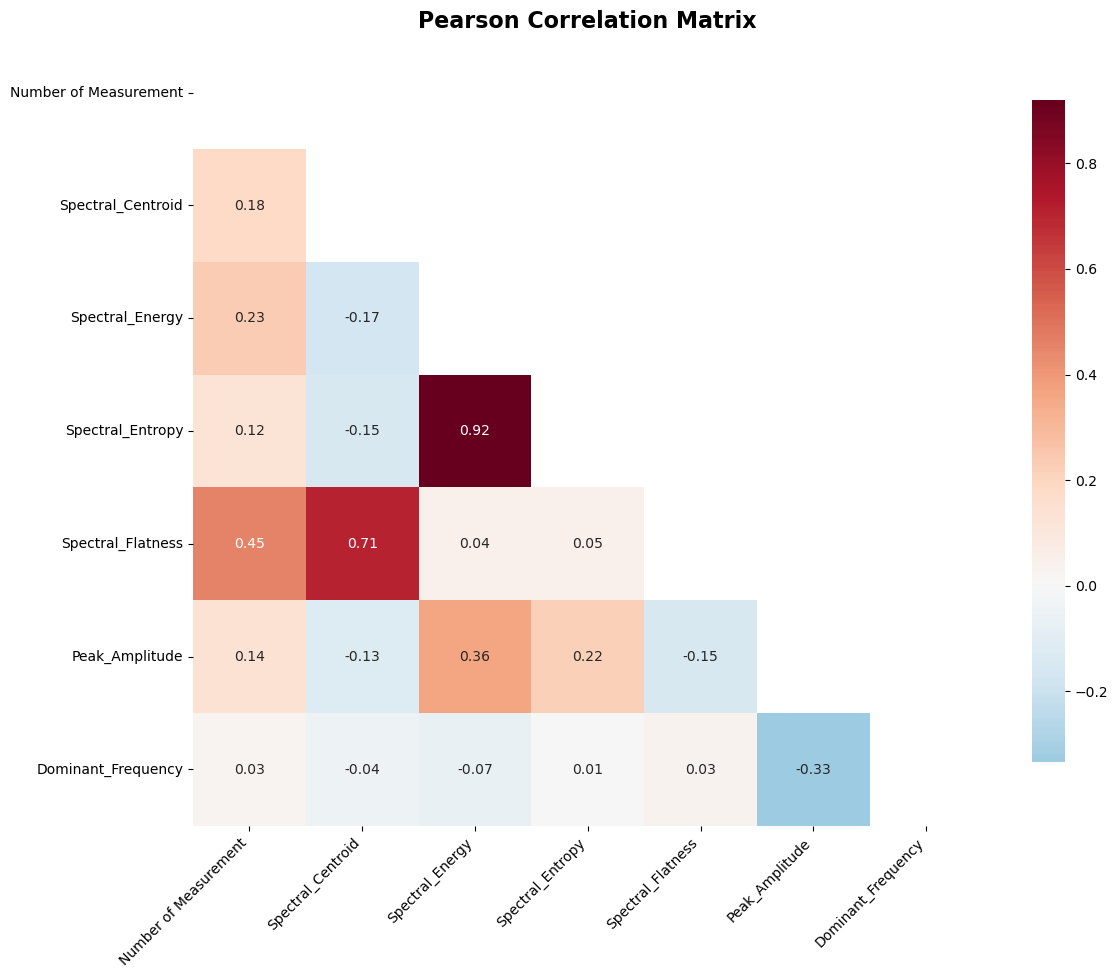


HIGH CORRELATIONS (|r| > 0.7)
----------------------------------------
Spectral_Centroid <-> Spectral_Flatness: r = 0.705
Spectral_Energy <-> Spectral_Entropy: r = 0.920

FEATURES TO KEEP (low correlation):
----------------------------------------
- Number of Measurement
- Spectral_Centroid
- Spectral_Energy
- Peak_Amplitude
- Dominant_Frequency
PEARSON CORRELATION ANALYSIS
Features analyzed: 9
Shape of correlation matrix: (9, 9)


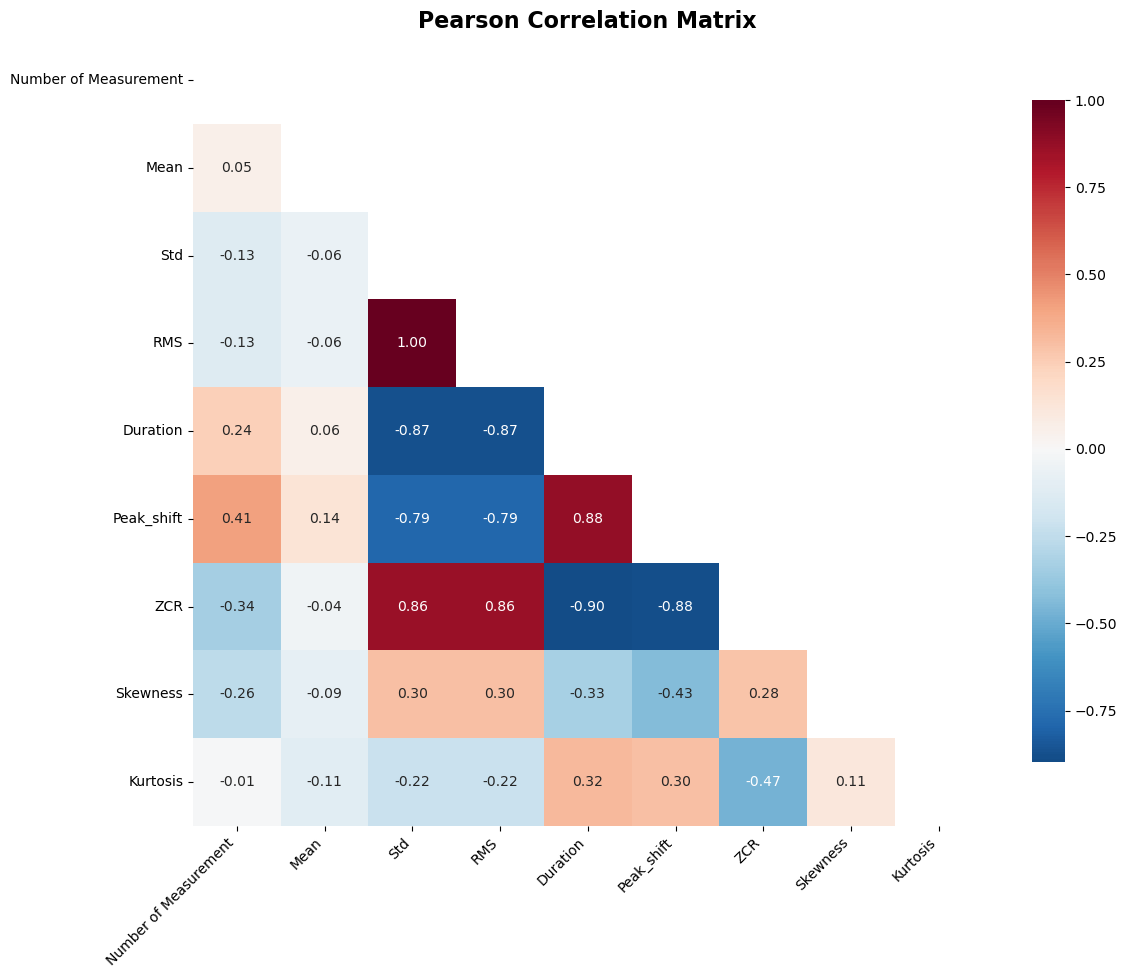


HIGH CORRELATIONS (|r| > 0.88)
----------------------------------------
Std <-> RMS: r = 1.000
Duration <-> ZCR: r = -0.898
Peak_shift <-> ZCR: r = -0.885

FEATURES TO KEEP (low correlation):
----------------------------------------
- Number of Measurement
- Mean
- Std
- Duration
- Peak_shift
- Skewness
- Kurtosis


In [72]:
def calculate_pearson_correlation(final_combined_df):
   """
   Calculate Pearson correlation coefficients for all numeric features
   """
   # Get numeric columns only (exclude ID and Label)
   numeric_cols = final_combined_df.select_dtypes(include=[np.number]).columns.tolist()
   if 'Measurement Number' in numeric_cols:
       numeric_cols.remove('Measurement Number')
   
   # Calculate correlation matrix
   correlation_matrix = final_combined_df[numeric_cols].corr(method='pearson')
   
   print("PEARSON CORRELATION ANALYSIS")
   print("=" * 50)
   print(f"Features analyzed: {len(numeric_cols)}")
   print(f"Shape of correlation matrix: {correlation_matrix.shape}")
   
   return correlation_matrix, numeric_cols

def visualize_correlation_matrix(correlation_matrix, numeric_cols):
   """
   Visualize correlation matrix with heatmap
   """
   plt.figure(figsize=(12, 10))
   
   # Create heatmap
   mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
   sns.heatmap(correlation_matrix, 
               mask=mask,
               annot=True, 
               cmap='RdBu_r', 
               center=0,
               fmt='.2f',
               square=True,
               cbar_kws={"shrink": 0.8})
   
   plt.title('Pearson Correlation Matrix', fontsize=16, fontweight='bold')
   plt.xticks(rotation=45, ha='right')
   plt.yticks(rotation=0)
   plt.tight_layout()
   plt.show()

def find_high_correlations(correlation_matrix, threshold=0.7):
   """
   Find highly correlated feature pairs and return features to remove
   """
   print(f"\nHIGH CORRELATIONS (|r| > {threshold})")
   print("-" * 40)
   
   high_corr_pairs = []
   features_to_remove = []
   
   for i in range(len(correlation_matrix.columns)):
       for j in range(i+1, len(correlation_matrix.columns)):
           corr_value = correlation_matrix.iloc[i, j]
           if abs(corr_value) > threshold:
               feature1 = correlation_matrix.columns[i]
               feature2 = correlation_matrix.columns[j]
               high_corr_pairs.append((feature1, feature2, corr_value))
               print(f"{feature1} <-> {feature2}: r = {corr_value:.3f}")
               
               # Keep the first feature, remove the second
               if feature2 not in features_to_remove:
                   features_to_remove.append(feature2)
   
   if len(high_corr_pairs) == 0:
       print("No high correlations found")
   
   return high_corr_pairs, features_to_remove

def get_low_correlation_features(correlation_matrix, features_to_remove):
   """
   Get list of features with low correlation (to keep)
   """
   all_features = correlation_matrix.columns.tolist()
   low_correlation_features = [feature for feature in all_features if feature not in features_to_remove]
   
   print(f"\nFEATURES TO KEEP (low correlation):")
   print("-" * 40)
   for feature in low_correlation_features:
       print(f"- {feature}")
   
   return low_correlation_features

def full_correlation_analysis(final_combined_df, threshold):
   """
   Complete correlation analysis with visualization
   """
   # Calculate correlation matrix
   correlation_matrix, numeric_cols = calculate_pearson_correlation(final_combined_df)
   
   # Visualize
   visualize_correlation_matrix(correlation_matrix, numeric_cols)
   
   # Find high correlations
   high_corr_pairs, features_to_remove = find_high_correlations(correlation_matrix, threshold)
   
   # Get low correlation features
   low_correlation_features = get_low_correlation_features(correlation_matrix, features_to_remove)
   
   return correlation_matrix, high_corr_pairs, low_correlation_features

# Usage
correlation_matrix_fre, high_corr_pairs_fre, low_correlation_features_fre = full_correlation_analysis(features_df_freq, threshold=0.7)
correlation_matrix_time, high_corr_pairs_time, low_correlation_features_time = full_correlation_analysis(features_df_time, threshold=0.88)

In [74]:
# Keep low correlation frequency domain features
selected_features_freq = features_df_freq[low_correlation_features_fre + ['Label']]

# Keep low correlation time domain features
selected_features_time = features_df_time[low_correlation_features_time + ['Label']]

# Merge frequency and time domain features
final_combined_df = pd.merge(selected_features_freq, 
                          selected_features_time.drop('Label', axis=1), 
                          on='Number of Measurement', 
                          how='left')

print("Final combined DataFrame shape:", final_combined_df.shape)
print("Final combined DataFrame columns:", final_combined_df.columns.tolist())
print(final_combined_df.head())

Final combined DataFrame shape: (200, 12)
Final combined DataFrame columns: ['Number of Measurement', 'Spectral_Centroid', 'Spectral_Energy', 'Peak_Amplitude', 'Dominant_Frequency', 'Label', 'Mean', 'Std', 'Duration', 'Peak_shift', 'Skewness', 'Kurtosis']
   Number of Measurement  Spectral_Centroid  Spectral_Energy  Peak_Amplitude  \
0                    169        6679.480435     6.474553e+16    4.989209e+06   
1                    170        6572.786802     5.042881e+16    5.818913e+06   
2                    171        6571.812053     6.438985e+16    5.011761e+06   
3                    172        6615.900967     6.727036e+16    6.706146e+06   
4                    173        6641.830755     4.556376e+16    5.256110e+06   

   Dominant_Frequency Label      Mean         Std   Duration  Peak_shift  \
0         4021.632707    iO -0.011418  749.951901   9.996417    0.128512   
1         4563.541022    iO  0.014857  825.232658   8.017437    0.168349   
2         4625.571582    iO  0.0573

PCA FEATURE EXTRACTION
Original features: 10
PCA components: 3
Features used: ['Spectral_Centroid', 'Spectral_Energy', 'Peak_Amplitude', 'Dominant_Frequency', 'Mean', 'Std', 'Duration', 'Peak_shift', 'Skewness', 'Kurtosis']
Excluded from PCA: ['Number of Measurement', 'Label']

PCA RESULTS
--------------------
Explained variance ratio: [0.38378589 0.15336063 0.13132437]
Cumulative variance: [0.38378589 0.53714652 0.66847089]
Total variance explained: 0.668


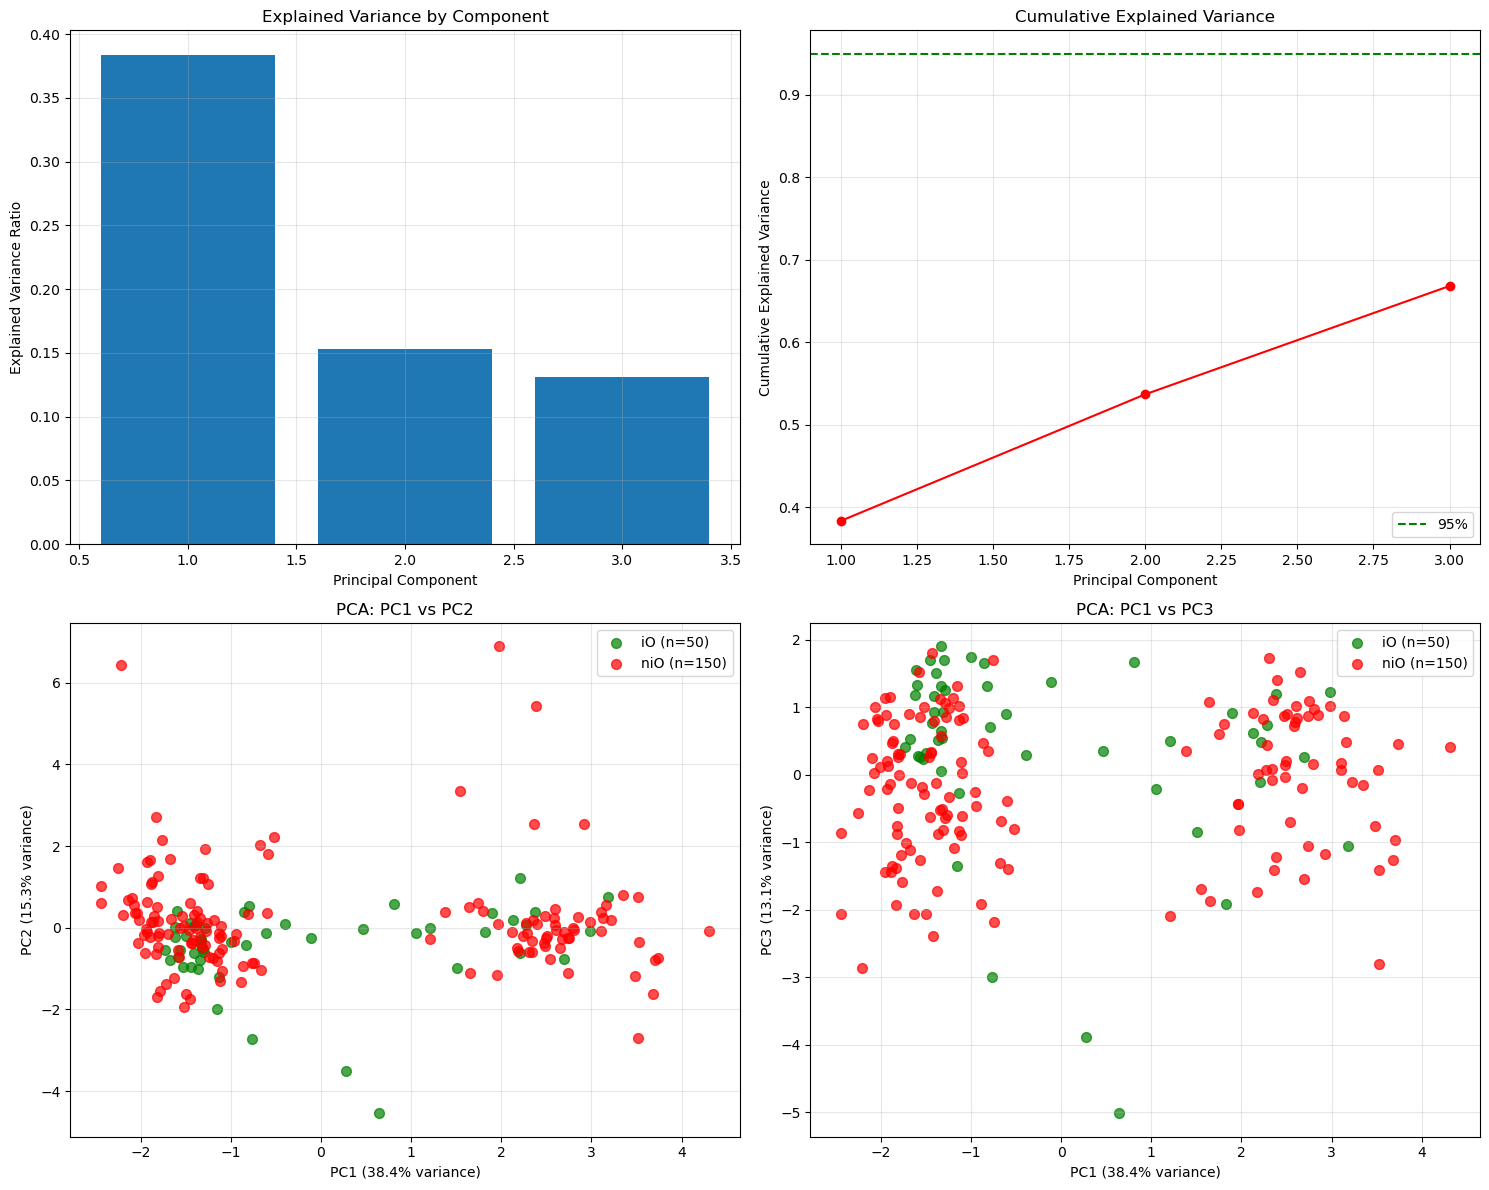


PCA COMPONENT ANALYSIS

Principal Component 1 (explains 38.4% variance):
Top contributing features:
  Duration: 0.499
  Peak_shift: 0.472
  Spectral_Energy: 0.455
  Std: -0.443
  Skewness: -0.235

Principal Component 2 (explains 15.3% variance):
Top contributing features:
  Kurtosis: 0.605
  Peak_Amplitude: -0.469
  Spectral_Centroid: 0.429
  Dominant_Frequency: 0.335
  Skewness: 0.270

Principal Component 3 (explains 13.1% variance):
Top contributing features:
  Dominant_Frequency: 0.602
  Peak_Amplitude: -0.487
  Spectral_Centroid: -0.400
  Kurtosis: -0.305
  Skewness: -0.210

PCA features saved to: pca_features.csv


In [83]:
def apply_pca_to_final_df(final_combined_df, n_components=3):
   """
   Apply PCA to final_combined_df and extract features
   """
   # Get numeric features (exclude ID and Label)
   numeric_cols = final_combined_df.select_dtypes(include=[np.number]).columns.tolist()
   
   # Ensure Number of Measurement and Label are excluded
   exclude_cols = ['Number of Measurement', 'Label']
   numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
   
   print("PCA FEATURE EXTRACTION")
   print("=" * 40)
   print(f"Original features: {len(numeric_cols)}")
   print(f"PCA components: {n_components}")
   print(f"Features used: {numeric_cols}")
   print(f"Excluded from PCA: {exclude_cols}")
   print()
   
   # Prepare data
   X = final_combined_df[numeric_cols].values
   labels = final_combined_df['Label'].values
   measurement_ids = final_combined_df['Number of Measurement'].values
   
   # Standardize features
   scaler = StandardScaler()
   X_scaled = scaler.fit_transform(X)
   
   # Apply PCA
   pca = PCA(n_components=n_components)
   X_pca = pca.fit_transform(X_scaled)
   
   # Print PCA results
   print("PCA RESULTS")
   print("-" * 20)
   print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
   print(f"Cumulative variance: {np.cumsum(pca.explained_variance_ratio_)}")
   print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.3f}")
   
   # Create PCA DataFrame with only PC1, PC2, PC3
   pca_columns = ['PC1', 'PC2', 'PC3']
   pca_df = pd.DataFrame(X_pca, columns=pca_columns)
   pca_df['Number of Measurement'] = measurement_ids
   pca_df['Label'] = labels
   
   return pca_df, pca, scaler, numeric_cols

def visualize_pca_results(pca_df, pca):
   """
   Visualize PCA results for PC1, PC2, PC3
   """
   fig, axes = plt.subplots(2, 2, figsize=(15, 12))
   
   # 1. Explained variance
   axes[0,0].bar(range(1, len(pca.explained_variance_ratio_)+1), 
                 pca.explained_variance_ratio_)
   axes[0,0].set_xlabel('Principal Component')
   axes[0,0].set_ylabel('Explained Variance Ratio')
   axes[0,0].set_title('Explained Variance by Component')
   axes[0,0].grid(True, alpha=0.3)
   
   # 2. Cumulative variance
   axes[0,1].plot(range(1, len(pca.explained_variance_ratio_)+1), 
                  np.cumsum(pca.explained_variance_ratio_), 'ro-')
   axes[0,1].axhline(y=0.95, color='g', linestyle='--', label='95%')
   axes[0,1].set_xlabel('Principal Component')
   axes[0,1].set_ylabel('Cumulative Explained Variance')
   axes[0,1].set_title('Cumulative Explained Variance')
   axes[0,1].legend()
   axes[0,1].grid(True, alpha=0.3)
   
   # 3. PC1 vs PC2 scatter plot
   colors = {'iO': 'green', 'niO': 'red'}
   for label in pca_df['Label'].unique():
       subset = pca_df[pca_df['Label'] == label]
       axes[1,0].scatter(subset['PC1'], subset['PC2'], 
                        c=colors.get(label, 'blue'), 
                        label=f'{label} (n={len(subset)})',
                        alpha=0.7, s=50)
   
   axes[1,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
   axes[1,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
   axes[1,0].set_title('PCA: PC1 vs PC2')
   axes[1,0].legend()
   axes[1,0].grid(True, alpha=0.3)
   
   # 4. PC1 vs PC3 scatter plot
   for label in pca_df['Label'].unique():
       subset = pca_df[pca_df['Label'] == label]
       axes[1,1].scatter(subset['PC1'], subset['PC3'], 
                        c=colors.get(label, 'blue'), 
                        label=f'{label} (n={len(subset)})',
                        alpha=0.7, s=50)
   
   axes[1,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
   axes[1,1].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)')
   axes[1,1].set_title('PCA: PC1 vs PC3')
   axes[1,1].legend()
   axes[1,1].grid(True, alpha=0.3)
   
   plt.tight_layout()
   plt.show()

def analyze_pca_components(pca, numeric_cols, n_top=5):
   """
   Analyze what each principal component represents (PC1, PC2, PC3)
   """
   print("\nPCA COMPONENT ANALYSIS")
   print("=" * 40)
   
   for i, component in enumerate(pca.components_):
       print(f"\nPrincipal Component {i+1} (explains {pca.explained_variance_ratio_[i]:.1%} variance):")
       
       # Get top contributing features
       feature_contributions = list(zip(numeric_cols, component))
       feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
       
       print("Top contributing features:")
       for feature, contribution in feature_contributions[:n_top]:
           print(f"  {feature}: {contribution:.3f}")

def save_pca_results(pca_df, filename='pca_features.csv'):
   """
   Save PCA results
   """
   pca_df.to_csv(filename, index=False)
   print(f"\nPCA features saved to: {filename}")

def complete_pca_analysis(final_combined_df, n_components=3):
   """
   Complete PCA analysis with PC1, PC2, PC3
   """
   # Apply PCA
   pca_df, pca, scaler, numeric_cols = apply_pca_to_final_df(final_combined_df, n_components)
   
   # Visualize results
   visualize_pca_results(pca_df, pca)
   
   # Analyze components
   analyze_pca_components(pca, numeric_cols)
   
   # Save results
   save_pca_results(pca_df)
   
   return pca_df, pca, scaler

# Usage
pca_df, pca_model, scaler = complete_pca_analysis(final_combined_df, n_components=3)

In [ ]:
print("PCA DataFrame:")
print(pca_df.head())
print("\nPCA DataFrame shape:", pca_df.shape)
print("PCA DataFrame columns:", pca_df.columns.tolist())

PCA DataFrame:
        PC1       PC2       PC3  Number of Measurement Label
0 -0.793707  0.522260  0.707868                    169    iO
1 -0.827960 -0.422101  1.320004                    170    iO
2  0.804607  0.581941  1.668753                    171    iO
3 -0.394608  0.093606  0.290698                    172    iO
4 -1.408502  0.052999  0.922899                    173    iO

PCA DataFrame shape: (200, 5)
PCA DataFrame columns: ['PC1', 'PC2', 'PC3', 'Number of Measurement', 'Label']


# Modeling